In [548]:
import numpy as np
import os
from scipy import constants as C
import pandas as pd
import random
import glob
import re
from matplotlib.colors import LogNorm
import warnings
import h5py
warnings.filterwarnings('ignore')

In [496]:
# 模拟类
import time
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import random
import scipy as sp
from scipy import constants as C
from scipy.constants import physical_constants as PC
from scipy import stats as st
from scipy.special import erf
import math
import os
# import scienceplots
# import PyGeopack as gp
import copy
import glob
import matplotlib.animation as animation
from matplotlib import pyplot as plt
from matplotlib import cm, ticker
import matplotlib.patches as patches


class prt_sim(object):

    q = C.elementary_charge  # proton charge /Cb
    mu = C.proton_mass  # proton mass /kg
    Re = 0.6371E7  # one Earth Radius /m
    # Aw0 = (twopi / 0.864E-5) * 1E-8  # Angular velosity of earth
    c = C.speed_of_light  # speed of light /m/s


    def __init__(self, input_parameters, pulse_parameters, background_parameters):
        input_parameters = copy.deepcopy(input_parameters)
        pulse_parameters = copy.deepcopy(pulse_parameters)
        background_parameters = copy.deepcopy(background_parameters)
        
        self.input_parameters = input_parameters
        self.background_parameters = background_parameters
        self.pulse_parameters = pulse_parameters 

    @property
    def input_parameters(self):
        return self._input_parameters

    @input_parameters.setter
    def input_parameters(self, value):
        if not isinstance(value, dict):
            raise TypeError("input parameters have to be dict type")
        
        allowed_keys = ["xmu", 'IOPT', 'raddist0', 'longi0', 'KEc0', 'pa',
                        'timedir', 'Tout', 'Dmin', 'pulse_flag', 'tmax', 'model', 'date']
        # 电荷正负，地磁扰动指数IOPT，粒子初始位置，经度，粒子初始动能，模拟时间步长，结果输出
        # 时间，最小距离步长，脉冲电场指示，最大模拟时间, 磁场模型, 日期（磁场模型中使用）

        for key in value.keys():
            if key not in allowed_keys:
                raise ValueError(f'key "{key}" is not allowed') 
            
        self._input_parameters = value

    @property
    def background_parameters(self):
        return self._background_parameters
    
    @background_parameters.setter
    def background_parameters(self, value):
        if not isinstance(value, dict):
            raise TypeError("pulse parameters have to be dict type")
        
        allowed_keys = ['phi0', 'E0', 'omega', 'guass_flag', 'random_phi_flag']
        for key in value.keys():
            if key not in allowed_keys:
                raise ValueError(f'key "{key}" is not allowed') 
            
        self._background_parameters = value

    @property
    def pulse_parameters(self):
        return self._pulse_parameters

    @pulse_parameters.setter
    def pulse_parameters(self, value):
        if not isinstance(value, dict):
            raise TypeError("pulse parameters have to be dict type")
        
        allowed_keys = ['phi0', 'E0', 'c0', 'c1', 'c2', 'c3', 'p', 'va', 'ri', 'ti', 'di', 'rd', 'vpulse', 'duration']

        for key in value.keys():
            if key not in allowed_keys:
                raise ValueError(f'key "{key}" is not allowed') 
            
        self._pulse_parameters = value


    def prt_sim(self): # 一个粒子的模拟
        KEc0 = self.input_parameters.get("KEc0") # 粒子
        longi0 = self.input_parameters.get("longi0") # 初始位置经度
        raddist0 = self.input_parameters.get("raddist0") # 初始L值
        pa = self.input_parameters.get("pa") # 投掷角

        if self.input_parameters.get("xmu") == -1: # 电子
            m0 = C.electron_mass # 质量
            qabs = np.abs(C.elementary_charge) # 电荷
            self.q = -self.q
        elif self.input_parameters.get("xmu") == 1: # 质子
            m0 = C.proton_mass
            qabs = np.abs(C.elementary_charge)

        IOPT = self.input_parameters.get("IOPT")
        tmax = self.input_parameters.get("tmax")

        # depend of external magnetic field model(MOD), OPPT = kp + 1
        kp = IOPT - 1 # kp index 

        tilt = 0 # tilt angle
        
        # 初始位置转换为直角坐标系下（MAG)
        xc0 = raddist0 * np.cos(np.deg2rad(longi0))
        yc0 = raddist0 * np.sin(np.deg2rad(longi0))
        zc0 = 0 # 只考虑磁赤道电子
        mlt0 = np.mod(np.rad2deg(math.atan2(-1 * yc0, -1 * xc0)/15)+24, 24) # 初始磁地方时
        KEc0joule = KEc0 * 1000 * qabs  # energy in Joule
        
        # Calculating magnetic filed at position ptc0=(xc0, yc0, zc0)
        # pulse_flag = self.input_parameters.get("pulse_flag")
        Bx, By, Bz = self.MAG(0, tilt, xc0, yc0, zc0) # magnetic field using inferred model in GSM coordinates
        # Ew1, Bu1 = self.pulse_fields(pulse_flag, 0, xc0, yc0, zc0) # pulse E field and pertubated B field  
        # # Ew1_a, Bu1_a = pulse_fields_v0()

        # Bx = Bdx + Bu1[0] * 1E9
        # By = Bdy + Bu1[1] * 1E9
        # Bz = Bdz + Bu1[2] * 1E9
        Bt = np.sqrt(Bx**2 + By**2 + Bz**2) # 总磁场，包含背景模型磁场  

        # ptc0: position-vector of initial gyrocenter, GSM coordinates

        ptc0 = np.array([xc0, yc0, zc0])

        # total energy = kinetic energy + rest energy

        Wtotjoule = KEc0joule + m0 * self.c ** 2

        # particle momnetum, from: W**2 = (P*C)**2 + (m0*c**2)**2

        ptotal2 = (Wtotjoule**2 - (m0 * self.c**2)**2) / self.c**2
        pperp2 = ptotal2 * (np.sin(np.deg2rad(pa)))**2
        # relativistic energy factor, gamma = (KE + m0*c**2)/(m0*c**2)

        gamma = (KEc0joule + m0 * self.c**2)/(m0 * self.c**2)
        Mr = pperp2 / (2 * m0 * Bt * qabs)  # first adiabatic invariant eV/nT

        rgc_o = np.multiply(ptc0, self.Re) # m
        VD_o, Wtot = self.DERIV(0, rgc_o, tilt, m0, Mr, qabs)
        VDmag = np.sqrt(np.dot(VD_o, VD_o)) # 漂移速度大小

        # initial time step, dt:
        dphi = 3  # this is the initial change in phi per time step, in degrees
        rad_dist = raddist0
        dt = dphi * 2 * np.pi * rad_dist * self.Re / (360 * VDmag)

        istop = 0
        time = 0
        equ0 = np.zeros(3) # 初始化赤道映射点的位置

        rgc_oRE_list = []
        w_list = []
        t_list = []
        i = 0
        while istop == 0:
            rgc_oRE = np.multiply(rgc_o, 1/self.Re)    
            rgc_oRE_list.append(rgc_oRE)
            w_list.append(Wtot)
            t_list.append(time)        

            timeT = time
            rgc_n = self.RK4(rgc_o, VD_o, time, dt, tilt, m0, Mr, qabs)
            VD_n, Wtot = self.DERIV(time, rgc_n, tilt, m0, Mr, qabs)
            VD_oRE = np.multiply(VD_o, 1/self.Re)
            VD_nRE = np.multiply(VD_n, 1/self.Re)            

            rgc_o = rgc_n
            time = timeT + dt            
            VD_o, Wtot = self.DERIV(time, rgc_o, tilt, m0, Mr, qabs)    
            rgc_nRE = np.multiply(rgc_n, 1/self.Re)
            equ = rgc_nRE # 赤道位置
            phi_gc = np.mod(np.rad2deg(math.atan2(equ[1], equ[0])) + 360, 360) # 经度

            Bx, By, Bz = self.MAG(time, tilt, equ[0], equ[1], equ[2])
            # Ew1, Bu1 = self.pulse_fields(pulse_flag, time, equ[0], equ[1], equ[2])
            # # pulse_fields_v0()
            # Btotx = Bdx + Bu1[0] * 1E9
            # Btoty = Bdy + Bu1[1] * 1E9
            # Btotz = Bdz + Bu1[2] * 1E9
            Btequ = np.sqrt(Bx**2 + By**2 + Bz**2)
            sinpequ = 1
            pequ = np.rad2deg(np.arcsin(sinpequ))

            # condition for output: minimum distance Dmin
            D2 = (equ[0] - equ0[0])**2 + (equ[1] -
                                        equ0[1])**2 + (equ[2] - equ0[2])**2
            Dist = np.sqrt(D2)
            # If Dsit < Dmin

            # rgc_oRE = np.multiply(rgc_o, 1/self.Re)
            VD_oRE = np.multiply(VD_o, 1/self.Re)
            rad_dist = np.sqrt(equ[0]**2 + equ[1]**2)
            ptot2_inst = (Wtot**2 - (m0*self.c**2)**2)/self.c**2
            Mr_inst = ptot2_inst / (2 * m0 * Btequ * qabs)
            KE_inst_keV = (Wtot-(m0*self.c**2))/(1000*qabs)
            gamma_inst = Wtot/(m0 * self.c**2)
            # veloc_inst
            # veloc_fact

            equ0 = equ

            # Mr = Mr_inst
            gamma = gamma_inst

            time_c = time / 60
            r_c = rad_dist

            i += 1
            if((time_c >= 40) and (r_c >= 13.5)):
                print("r out of range")
                istop = 1

            # Max running time:
            if(time_c >= tmax):
                print(time_c)
                print("max running time")
                istop = 1
            # Rmax on night side:
            if((equ[0] < 0) and (r_c >= 18)):
                print("rmax night side")
                istop = 1

            # Rmax on day side:
            if((equ[1] >= 0) and (r_c >= 20)):
                print("rmax day side")
                istop = 1

            # Rmin (about same for nightside and dayside)
            if(r_c <= 1):
                print("rmin")
                istop = 1                
        return rgc_oRE_list, t_list, w_list

    def MAG(self, t, tilt, x, y, z):
        # 默认gsm坐标系下偶极场
        #  待添加其他模型
        PS = np.deg2rad(tilt)
        SPS = np.sin(PS)
        CPS = np.cos(PS)
        PSI = PS
        M = 1
        P = x ** 2
        U = z ** 2
        V = 3 * z * x
        T = y ** 2
        Q = 0.7 * 0.31E5 / np.sqrt(P + T + U) ** 5
        Bx = Q * ((T + U - 2 * P) * SPS - V * CPS)
        By = -3 * y * Q * (x * SPS + z * CPS)
        Bz = Q * ((P + T - 2 * U) * CPS - V * SPS)
        Bx = 0
        By = 0
        Bz = 0.311 * (np.sqrt(x**2 + y**2))**(-3) * 1e5

        pulse_flag = self.input_parameters.get("pulse_flag")
        Epw, Bpu0 = self.pulse_fields(pulse_flag, t, x, y, z)  # pulse_fields()

        Bxtot = Bx + Bpu0[0] * 1e9
        # print(Bdx, Bdy, Bdz, np.array(Bpu) * 1e9)
        Bytot = By + Bpu0[1] * 1e9
        Bztot = Bz + Bpu0[2] * 1e9

        return Bxtot, Bytot, Bztot
    

    def pulse_fields(self, pulse_flag, t, x, y, z):

        rv = np.float32(np.array([x, y, z]))
        Epulse = np.zeros_like(rv)
        Bpulse = np.zeros_like(rv)
        if pulse_flag == 0:
            return Epulse, Bpulse

        elif pulse_flag == 1:
            phi0 = self.pulse_parameters.get("phi0")
            E0 = self.pulse_parameters.get("E0")
            c0 = self.pulse_parameters.get("c0")
            c1 = self.pulse_parameters.get("c1")
            c2 = self.pulse_parameters.get("c2")
            c3 = self.pulse_parameters.get("c3")
            p = self.pulse_parameters.get("p")
            va = self.pulse_parameters.get("va")
            ri = self.pulse_parameters.get("ri")
            ti = self.pulse_parameters.get("ti")
            di = self.pulse_parameters.get("di")
            rd = self.pulse_parameters.get("rd") 
            # vpulse = self.pulse_parameters.get("vpulse")
            vpulse = self.vpulse(np.linalg.norm(rv)*self.Re)

        else:
            raise TypeError(r"pulse flag must be 0 or 1")
        # if t < self.pulse_parameters.get("duration"):
        pulse_temp = {
            "phi0": phi0,
            "E0": E0,
            "c0": c0,
            "c1": c1,
            "c2": c2,
            "c3": c3,
            "p": p,
            "va": va,
            "ri": ri,
            "ti": ti,
            "di": di,
            "rd": rd,
            'vpulse':vpulse
        }       
        pulse_temp2 = {
            "phi0": phi0,
            "E0": -E0,
            "c0": c0,
            "c1": c1,
            "c2": c2,
            "c3": c3,
            "p": p,
            "va": va,
            "ri": ri,
            "ti": ti+self.pulse_parameters.get("duration"),
            "di": di,
            "rd": rd,
            'vpulse':vpulse}            
        # calculate the unit vectors in spherical coord at r = (x, y, z):

        er, eu, ew = self.UNIT_Sph(rv)
        # get the local time of position rv = (x,y z)
        phi = np.mod(np.rad2deg(np.arctan2(y, x)) + 360, 360)

        # radial distance from center of Earth
        r = np.sqrt(x**2 + y**2 + z ** 2) * self.Re  # m
        EFw = self.Ephi(t, r, phi, pulse_temp)
        BFu = self.Btheta(t, r, phi, pulse_temp)
        BFr = self.Brad(t, r, phi, pulse_temp)

        Bu = np.zeros_like(rv)
        Br = np.zeros_like(rv)

        
        Epulse[0], Epulse[1], Epulse[2] = -EFw * ew[0], -EFw * ew[1], -EFw * ew[2]
        Bu[0], Bu[1], Bu[2] = -BFu * eu[0], -BFu * eu[1], -BFu * eu[2]
        Br[0], Br[1], Br[2] = -BFr * er[0], -BFr * er[1], -BFr * er[2]
        Bpulse = Bu + Br      
        #####################
        EFw2 = self.Ephi(t, r, phi, pulse_temp2)
        BFu2 = self.Btheta(t, r, phi, pulse_temp2)
        BFr2 = self.Brad(t, r, phi, pulse_temp2)

        Bu2 = np.zeros_like(rv)
        Br2 = np.zeros_like(rv)

        Epulse2 = np.zeros_like(rv)
        Bpulse2 = np.zeros_like(rv)
        Epulse2[0], Epulse2[1], Epulse2[2] = -EFw2 * ew[0], -EFw2 * ew[1], -EFw2 * ew[2]
        Bu2[0], Bu2[1], Bu2[2] = -BFu2 * eu[0], -BFu2 * eu[1], -BFu2 * eu[2]
        Br2[0], Br2[1], Br2[2] = -BFr2 * er[0], -BFr2 * er[1], -BFr2 * er[2]
        Bpulse2 = Bu2 + Br2     
        
        Epulse = Epulse + Epulse2
        # Bpulse = Bpulse + Bpulse2
        Bpulse = np.zeros_like(Bpulse)
        return Epulse, Bpulse

    def Ephi(self, t, r, phi, pulse_temp):
        # input t:time-sec, r:rad.dist-m, phi:loctime-degrees
        # pulse_temp:phi0, E0, c0, c1, c2, c3, p, va, ri, ti, di, rd
        # return EFw

        # vr = self.vpulse(r)
        # vr = pulse_temp.get("vpulse")
        vr = self.vpulse(r)
        phi0 = pulse_temp.get("phi0")
        phis = (phi - phi0) * 1.745329E-2
        E0 = pulse_temp.get("E0")
        c0 = pulse_temp.get("c0")
        c1 = pulse_temp.get("c1")
        c2 = pulse_temp.get("c2")
        c3 = pulse_temp.get("c3")
        p = pulse_temp.get("p")
        rd = pulse_temp.get("rd")
        va = pulse_temp.get("va")
        ri = pulse_temp.get("ri")
        ti = pulse_temp.get("ti")
        di = pulse_temp.get("di")
        t0 = (c3 * self.Re/va) * (1 - np.cos(phis))
        iexp = (r - ri + vr * (t-t0-ti))/di

        rexp = (r - ri - c0*vr*(t-t0-ti)- rd*self.Re) / di 
        # rexp = (r - 2*ri + rd * self.Re - vr * (t-t0-ti)) / di
        rexp = (r - 2 * rd * self.Re + ri - vr * (t-t0-ti)) / di

        E0ampl = E0 * 1E-3 * (1 + c1 * np.cos(phis))**p # V/m, E0 in mV/m; electric field emplitude with respect to phis and parameter p
        EFw = E0ampl * (np.exp(-iexp**2) + c2 * np.exp(-rexp**2))  # in V/m
        return EFw

    def Btheta(self, t, r, phi, pulse_temp):
        vr = self.vpulse(r)
        phi0 = pulse_temp.get("phi0")
        phis = (phi - phi0) * 1.745329E-2
        E0 = pulse_temp.get("E0")
        c0 = pulse_temp.get("c0")
        c1 = pulse_temp.get("c1")
        c2 = pulse_temp.get("c2")
        c3 = pulse_temp.get("c3")
        p = pulse_temp.get("p")
        rd = pulse_temp.get("rd")
        va = pulse_temp.get("va")
        ri = pulse_temp.get("ri")
        ti = pulse_temp.get("ti")
        ti = ti + 500
        di = pulse_temp.get("di")            
        di = pulse_temp.get("di")
        di = di / 2
        vr = vr/7
        ri = ri * 0.7
        t0 = (c3 * self.Re/va) * (1 - np.cos(phis))
        iexp = (r - ri + vr * (t-t0-ti))/di


        rexp = (r - ri - c0*vr*(t-t0-ti)- rd*self.Re) / di 
        # rexp = (r - 2*ri + rd * self.Re - vr * (t-t0-ti)) / di
        rexp = (r - 2 * rd * self.Re + ri - vr * (t-t0-ti)) / di

        B0 = 15 * 1e-9
        B0ampl = B0 * (1 + c1 * np.cos(phis))**p 
        BFu = B0ampl * (np.exp(-iexp**2) + c2 * np.exp(-rexp**2))  
        return BFu       

    # def Btheta(self, t, r, phi, pulse_temp):
    #     # input t:time-sec, r:raddist-m phi:loctime-degrees
    #     # pulse_temp:phi0, E0, c0, c1, c2, c3, p, va, ri, ti, di, rd
    #     # return Bfu(T)
    #     # vr = pulse_temp.get("vpulse")
    #     vr = self.vpulse(r)
    #     phi0 = pulse_temp.get("phi0")
    #     phis = (phi - phi0) * 1.745329E-2
    #     E0 = pulse_temp.get("E0")
    #     c0 = pulse_temp.get("c0")
    #     c1 = pulse_temp.get("c1")
    #     c2 = pulse_temp.get("c2")
    #     c3 = pulse_temp.get("c3")
    #     p = pulse_temp.get("p")
    #     rd = pulse_temp.get("rd")
    #     va = pulse_temp.get("va")
    #     ri = pulse_temp.get("ri")
    #     ti = pulse_temp.get("ti")
    #     di = pulse_temp.get("di")
    #     t0 = (c3 * self.Re/va) * (1 - np.cos(phis))
    #     iexp = (r - ri + vr * (t-t0-ti))/di
    #     rexp = (r - ri - c0*vr*(t-t0-ti)-rd*self.Re) / di

    #     E0ampl = E0 * 1E-3 * (1 + c1 * np.cos(phis))**p # 
    #     dE0ampl = E0 * 1E-3 * p * (1 + c1 * np.cos(phis))**(p-1) # partial differentiation with respect to phis

    #     dvr = 0 # dv/dr, vpulse=const in this case
    #     Bu1_in_a = np.exp(-iexp**2)*(1+dvr*(t-t0-ti))/vr
    #     Bu1_in_b = -(di*np.sqrt(np.pi)*dvr/(2*vr**2))

    #     Bu1_re_a = np.exp(-rexp**2)*(-1.0+dvr*(t-t0-ti))/vr
    #     Bu1_re_b = (di*np.sqrt(np.pi)*dvr/(2*c0*vr**2))*(-1+erf(rexp))
    #     Bu1 = E0ampl * ( (Bu1_in_a + Bu1_in_b) - c2*(Bu1_re_a + Bu1_re_b) )

    #     Bu2_in = (1+erf(iexp))/(2*r*vr)
    #     Bu2_re = (-1+erf(rexp))/(2*r*vr)

    #     Bu2 = E0ampl*di*np.sqrt(np.pi)*(Bu2_in+(c2/c0)*Bu2_re)

    #     BFu = Bu1+Bu2
    #     print(BFu)
    #     return BFu

    def Brad(self, t, r, phi, pulse_temp):
        # 待补充
        # vr = pulse_temp.get("vpulse")
        vr = self.vpulse(r)
        phi0 = pulse_temp.get("phi0")
        phis = (phi - phi0) * 1.745329E-2
        E0 = pulse_temp.get("E0")
        c0 = pulse_temp.get("c0")
        c1 = pulse_temp.get("c1")
        c2 = pulse_temp.get("c2")
        c3 = pulse_temp.get("c3")
        p = pulse_temp.get("p")
        rd = pulse_temp.get("rd")
        va = pulse_temp.get("va")
        ri = pulse_temp.get("ri")
        ti = pulse_temp.get("ti")
        di = pulse_temp.get("di")
        t0 = (c3 * self.Re/va) * (1 - np.cos(phis))
        iexp = (r - ri + vr * (t-t0-ti))/di
        rexp = (r - ri - c0*vr*(t-t0-ti)-rd*self.Re) / di

        E0ampl = E0 * 1E-3 * (1 + c1 * np.cos(phis))**p # 
        Br_in = E0ampl*di*np.sqrt(np.pi)*( -1+erf(iexp))/(2*r*vr)
        Br_re = (c2/c0)*E0ampl*di*np.sqrt(np.pi)*(1+erf(rexp))/(2*r*vr)

        urad = np.arcsin(1)	# equatorial plane: theta = 90 deg

        BFr = -(1/np.tan(urad))*(Br_in + Br_re)
        return BFr
    
    def vpulse(self, r):
        vpulse = self.pulse_parameters.get("vpulse") # m/s
        if vpulse == 1:
            a = 53.15 * 0.8
            b = 0.0093 * 0.8
            vpulse = a * 1e3 + b * r
            return vpulse
        else:
            return vpulse

    def dvpulse(self, r):
        pass

    def ddvpulse(self, r):
        pass

    def DERIV(self, xt, rgc, tilt, m0, Mr, qabs):
        # relativistic 0th-order electic-force drift and 1st order gradient-B drift velocities
        # input: xt (time, in seconds), rgc (gyrocenter, in meters)
        # return: VD[3](guiding center velocity, in meters/sec)

        rgcRe = np.multiply(rgc, 1/self.Re) # rgc in m, rgcRe in Re
        xgcRe = rgcRe[0]
        ygcRe = rgcRe[1]
        zgcRe = rgcRe[2]

        # unit vectors in rgc:
        e1, e2, e3 = self.UNITEX(xt, rgcRe, tilt) # e1 points along the direction of magnetic field(dipole + external)

        # define step-size ds: used in subs perpgradB, bdelb, bdotdelB
        ds = 1E-4  # Re

        # magnetic field calculations at rgc:
        Bx, By, Bz = self.MAG(xt, tilt, xgcRe, ygcRe, zgcRe)

        pulse_flag = self.input_parameters.get("pulse_flag")
        Epw, Bpu = self.pulse_fields(pulse_flag, xt, xgcRe, ygcRe, zgcRe)  # pulse_fields()
        # Epw_a, Bpu_a = np.zeros(3), np.zeros(3)  # pulse_fields_a()
        # Bx = Bdx + Bpu[0] * 1e9 + Bpu_a[0] * 1e9 # nt
        # # print(Bdx, Bdy, Bdz, np.array(Bpu) * 1e9)
        # By = Bdy + Bpu[1] * 1e9 + Bpu_a[1] * 1e9
        # Bz = Bdz + Bpu[2] * 1e9 + Bpu_a[2] * 1e9  
        Bt = np.sqrt(Bx**2 + By**2 + Bz**2)
        Bt1 = 1 / Bt

        # new perpendicular relativistic particle momentum
        pperp2 = 2 * m0 * Bt * Mr * qabs
        # for 90 degree pitch angle particle, pperp2 = ptotl2
        ptotl2 = pperp2
        # New total particle energy in joules(kinetic + rest)
        Wtotjoule2 = ptotl2 * self.c**2 + (m0 * self.c**2)**2
        Wtotjoule = np.sqrt(Wtotjoule2)

        Wtot = Wtotjoule
        w_kinetic = Wtot/C.elementary_charge/1e6-0.511

        # new gamma
        gamma = (Wtotjoule) / (m0 * self.c**2)
        gamma1 = 1 / gamma

        # gradient of unperturbed magnetic field
        pgrB = self.perpgradB(xt, rgcRe, ds, tilt)  # pgrB in nt/Re

        e1_x_pgrB = np.cross(e1, pgrB)
        vfact = Mr * Bt1 * gamma1 * 1/self.Re * 1E9 * self.q / qabs
        Vg = np.multiply(e1_x_pgrB, vfact)

        # print(np.linalg.norm(Vg))
        # betasquare = 1 - 1 / (gamma**2)
        # L = np.sqrt(xgcRe**2 + ygcRe**2)
        # e1_x_pgrB_unit = np.multiply(e1_x_pgrB, 1 / np.linalg.norm(e1_x_pgrB))
        # vfact = 3.5e-2 * 2 * np.pi / 360 * self.Re * L**2 * betasquare * gamma
        # Vg = np.multiply(e1_x_pgrB_unit, vfact)
        # print(-np.linalg.norm(Vg))


        # Background electric field calculations:

        Exgc, Eygc, Ezgc = self.EfieldBackground(xt, xgcRe, ygcRe, zgcRe, Vg)
        # 0th order electric drift E x B / B**2
        Egc = np.zeros(3)
        Egc[0], Egc[1], Egc[2] = Exgc + Epw[0], Eygc + Epw[1], Ezgc + Epw[2]
        E_x_e1 = np.cross(Egc, e1)
        Vf = np.zeros(3)
        Vf[0], Vf[1], Vf[2] = E_x_e1[0]*Bt1 * \
            1E9, E_x_e1[1]*Bt1*1E9, E_x_e1[2]*Bt1*1E9

        # total drift velocity Vd = Vf + Vg
        VD = np.add(Vf, Vg) 
        return VD, Wtot


    def EfieldBackground(self, xt, x, y, z, Vg):
        return 0, 0, 0
        
    def UNIT_Sph(self, r):
        # calculate unit vector in spherical coord at position r=(x,y,z)
        # return er, eu, ew
        # er: radial unit vector
        # eu: longitute unit vector
        # ew: latitude unit vector
        er = np.zeros_like(r)
        eu = np.zeros_like(r)
        ew = np.zeros_like(r)

        x, y, z = r[0], r[1], r[2]
        rxy = np.sqrt(x**2 + y**2)
        rxy1 = 1 / rxy
        rxyz = np.sqrt(x**2 + y**2 + z**2)
        rxyz1 = 1 / rxyz
        
        er[0], er[1], er[2] = x * rxyz1, y * rxyz1, z*rxyz1     # er[0] = sin(u) * cos(w), er[1] = sin(u) * sin(w), er[2] = cos(u)
        
        eu[0], eu[1], eu[2] = z * rxyz1 * x * \
            rxy1, z * rxyz1 * y * rxy1, -rxy * rxyz1         # eu[0] = cos[u] * cos(w), eu[1] = cos(u) * sin(w), eu[2] = -sin(u)
        ew[0], ew[1], ew[2] = -y * rxy1, x * rxy1, 0         # ew[0] = -sin(w), ew[1] = cos(w), ew[2] = 0

        return er, eu, ew

    def UNITEX(self, t, r, tilt):
        # Calculates unit vectors at position r=r(x,y,z)
        #   e1   : direction of mag. fd. (DIPOLE + EXTERNAL FIELD IN UNITEX)
        #   e2   : unit vector in the direction of (ephi)x(e1)
        #   e3   : unit vector in the direction of (e1)x(e2)
        #   er   : radial unit vector
        #   etheta: longitudional unit vector
        #   ephi : latitudional unit vector

        PS = np.deg2rad(tilt)
        
        x = r[0]
        y = r[1]
        z = r[2]

        e1 = np.zeros(3)
        e2 = np.zeros(3)
        e3 = np.zeros(3)

        er, etheta, ephi = self.UNIT_Sph(r)

        Bx, By, Bz = self.MAG(t, tilt, x, y, z)
        Bt = np.sqrt(Bx**2 + By**2 + Bz**2)

        # unit vector along field line
        e1[0] = Bx / Bt
        e1[1] = By / Bt
        e1[2] = Bz / Bt

        # unit vector in direction of (ephi x e1)
        ephxe1 = np.cross(ephi, e1)
        xmag = np.sqrt(np.dot(ephxe1, ephxe1))
        xmag1 = 1 / xmag
        e2[0] = ephxe1[0] * xmag1
        e2[1] = ephxe1[1] * xmag1
        e2[2] = ephxe1[2] * xmag1

        # unit vector inside plain defined by closed magnetic field line e3=(e1 x e2)
        e3 = np.cross(e1, e2)

        return e1, e2, e3
    
    def perpgradB(self, t, r, ds, tilt):
        # calculate the perpendicular gradient of the magnetic field at point r = r(x, y, z)

        dsRe = ds
        e1, e2, e3 = self.UNITEX(t, r, tilt)
        x1p = r[0] + dsRe * e2[0]
        y1p = r[1] + dsRe * e2[1]
        z1p = r[2] + dsRe * e2[2]
        x1m = r[0] - dsRe * e2[0]
        y1m = r[1] - dsRe * e2[1]
        z1m = r[2] - dsRe * e2[2]  # in Re

        x2p = r[0] + dsRe * e3[0]
        y2p = r[1] + dsRe * e3[1]
        z2p = r[2] + dsRe * e3[2]
        x2m = r[0] - dsRe * e3[0]
        y2m = r[1] - dsRe * e3[1]
        z2m = r[2] - dsRe * e3[2]  # in Re  

        Bx, By, Bz = self.MAG(t, tilt, x1p, y1p, z1p)
        Bt1p = np.sqrt(Bx**2 + By**2 + Bz**2)

        Bx, By, Bz = self.MAG(t, tilt, x2p, y2p, z2p)
        Bt2p = np.sqrt(Bx**2 + By**2 + Bz**2)

        Bx, By, Bz = self.MAG(t, tilt, x1m, y1m, z1m)
        Bt1m = np.sqrt(Bx**2 + By**2 + Bz**2)

        Bx, By, Bz = self.MAG(t, tilt, x2m, y2m, z2m)  
        Bt2m = np.sqrt(Bx**2 + By**2 + Bz**2)

        pgrB1 = (Bt1p - Bt1m) / (2 * ds)
        pgrB2 = (Bt2p - Bt2m) / (2 * ds)

        pgrB = np.zeros(3)
        pgrB[0] = pgrB1 * e2[0] + pgrB2 * e3[0]
        pgrB[1] = pgrB1 * e2[1] + pgrB2 * e3[1]
        pgrB[2] = pgrB1 * e2[2] + pgrB2 * e3[2]

        # dot = np.dot(r, pgrB)
        # if dot > 0:
        #     print(dot)
        return pgrB

    def RK4(self, Y, DYDX, X, H, tilt, m0, Mr, qabs):
        # Fourth order Runge Kutta
        HH = H * 0.5
        H6 = H / 6
        XH = X + HH
        YT = np.add(Y, HH * DYDX)  # first step
        DYT, Wtot = self.DERIV(XH, YT, tilt, m0, Mr, qabs)  # second step
        YT = np.add(Y, HH * DYT)
        DYM, Wtot = self.DERIV(XH, YT, tilt, m0, Mr, qabs)  # third step
        YT = np.add(Y, H * DYM)
        DYM = np.add(DYT, DYM)
        DYT, Wtot = self.DERIV(XH, YT, tilt, m0, Mr, qabs)  # Fourth step

        YOUT = np.zeros(3)
        for i in range(3):
            YOUT[i] = Y[i] + H6 * (DYDX[i] + DYT[i] + 2 * DYM[i])

        X = X + H

        return YOUT

def pulse_observe(L, pulse_width, pulse_velocity, rebound_radio):
    # 绘制卫星在某一位置看到的电场
    input_parameters = {
        "xmu": -1, # -1 for electron, 1 for proton
        "IOPT": 1, # = kp + 1
        "raddist0": L, # initial L
        "longi0": 0, # intital phi
        'pa':90, # pitch angle
        "KEc0": 3400, # initial kinetic energy /KeV
        "timedir": 1,
        "Tout": 60,
        "Dmin": 0,
        "pulse_flag": 1, 
        "tmax": 30, # maximum simulation time /min
    } 
    pulse_parameters = {
        "phi0":0,
        "E0": 2, # 5mV/m
        "c0":1,
        "c1":1,
        "c2":rebound_radio,
        "c3":1,
        "p":1,
        "va":50000,
        "ri":0.6371E8 * 0.9, # m ri/vpulse determine the arrival time of pusle
        "ti":0,
        "di":pulse_width, # width of the pusle
        "rd":2.06, # pulse rebound at rd/2 Re
        "vpulse": pulse_velocity, # m/s
        "duration" : 450 # s 
    }
    p1 = prt_sim(input_parameters, pulse_parameters, {})
    p1_r, p1_t, p1_wtot = p1.prt_sim()
    r = [L, 0, 0]
    x = r[0]
    y = r[1]
    z = r[2]

    X, Y, T  = np.meshgrid(x, y, p1_t, indexing='ij')
    Z = np.zeros_like(X)
    p1_t = np.array(p1_t)
    pulse = p1.pulse_fields(1, p1_t, X, Y, Z)

    Epulse = pulse[0]
    B_tot = p1.MAG(p1_t, 0, X, Y, Z)
    # Epulse_magnitude = np.sqrt(Epulse[0]**2 + Epulse[1]**2 + Epulse[2]**2) # Epulse magnitude equalls ephi
    Epulse_magnitude = -1 * Epulse[1]
    B_magnitude = np.linalg.norm(B_tot, axis=0)
    emag = np.zeros_like(p1_t)
    for i in range(len(p1_t)):
        emag[i] = Epulse_magnitude[0,0, i]

    bmag = np.zeros_like(p1_t)
    for i in range(len(p1_t)):
        bmag[i] = np.squeeze(B_magnitude)[i]
    return p1_t, emag, bmag

30.024957707088433
max running time


Text(0.5, 0, 'time/s')

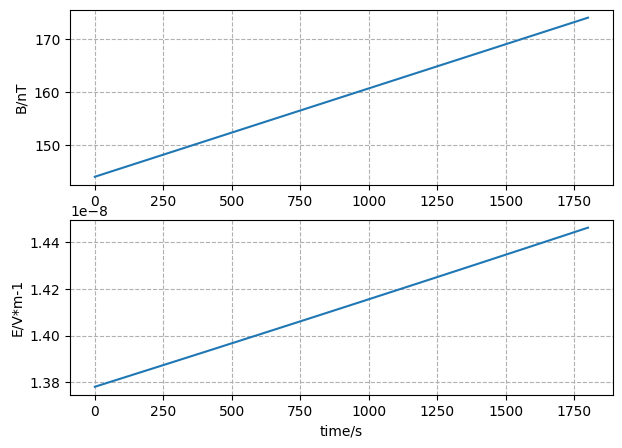

In [17]:
t_pulse, e_pulse, b = pulse_observe(6, pulse_width=2e7, pulse_velocity=100, rebound_radio=0)
b_adjust = np.linspace(0, 30, len(b))
b = b + b_adjust
fig, axs = plt.subplots(2, 1, dpi=100, figsize=(7,5))
axs[0].plot(t_pulse, b)
# axs[0].set_ylim(160, 220)
axs[0].grid(linestyle='--')
axs[0].set_ylabel("B/nT")
# axs[0].set_xlabel("time/s")
# axs[0].set_xlim(0, 5000)

axs[1].plot(t_pulse, e_pulse)
axs[1].grid(linestyle='--')
axs[1].set_ylabel("E/V*m-1")
axs[1].set_xlabel("time/s")

# axs[1].set_xlim(0, 5000)

In [ ]:
from matplotlib.animation import FuncAnimation

B = list()
for l in np.arange(4,8,0.1):
    t_pulse, e_pulse, b = pulse_observe(l, pulse_width=0.5e7, pulse_velocity=1e5, rebound_radio=0) # vpulse=1 represent velocity varies with radial distance
    B.append(b)
target_array = B[-1]
for i in range(len(B)-1):
    b = B[i]
    new_indices = np.linspace(0, len(b) - 1, len(target_array))
    interpolated_arr = np.interp(new_indices, np.arange(len(b)), b)
    B[i] = interpolated_arr

fig, ax = plt.subplots()
x = np.arange(4,8,0.1)
ax.grid(linestyle="--")
ax.set_xlabel("L")
ax.set_ylabel("B/nT")
line, = ax.plot(x, [b[0] for b in B])

def update(frame):
    line.set_ydata([b[frame] for b in B])
    ax.set_title("t={}s".format(frame))
    return line,

ani = FuncAnimation(fig, update, frames=np.arange(0, len(B[0]), 15), interval=2)
ani.save('./Bfield_animation.gif', writer='pillow')



In [ ]:
from matplotlib.animation import FuncAnimation

E = list()
for l in np.arange(1.1,8,0.3):
    t_pulse, e_pulse, b = pulse_observe(l, pulse_width=1e7, pulse_velocity=1e5, rebound_radio=1) # vpulse=1 represent velocity varies with radial distance
    E.append(e_pulse)
target_array = E[-1]
for i in range(len(E)-1):
    e = E[i]
    new_indices = np.linspace(0, len(e) - 1, len(target_array))
    interpolated_arr = np.interp(new_indices, np.arange(len(e)), e)
    E[i] = interpolated_arr

In [ ]:
def read_hdf5_data(batchfolder, batch_idx, kec, timestep):
    """
    读取指定batch、能量和时间点的数据
    
    Args:
        batch_idx (int): batch索引
        kec (float): 能量值
        timestep (int): 时间点索引
    
    Returns:
        np.ndarray: 数据数组
    """
    with h5py.File(f"{batchfolder}particle_data_batch{batch_idx}.h5", 'r') as f:
        return f[f"kec_{kec:.1f}/timestep_{timestep}/data"][:]

def read_hdf5_counts(batchfolder, batch_idx, kec):
    """
    读取指定batch和能量的粒子计数
    
    Args:
        batch_idx (int): batch索引
        kec (float): 能量值
    
    Returns:
        np.ndarray: 粒子计数数组
    """
    with h5py.File(f"{batchfolder}particle_data_batch{batch_idx}.h5", 'r') as f:
        return f[f"statistics/kec_{kec:.1f}_counts"][:]

def merge_batch_data(timestep, kec, batch_folder="./result_simpliest/fixedexp_doublegauss1.6/timepoint_data/"):
    """
    合并所有batch文件中特定时刻和能量的粒子数据
    
    Args:
        timestep (int): 时间点索引
        kec (float): 能量值
        batch_folder (str): batch文件所在文件夹路径
    
    Returns:
        np.ndarray: 合并后的数据数组
        int: 总粒子数
    """
    # 获取所有batch文件的索引
    batch_files = glob.glob(f"{batch_folder}/particle_data_batch*.h5")
    batch_indices = [int(f.split('batch')[-1].split('.')[0]) for f in batch_files]
    
    # 存储所有批次的数据
    all_data = []
    total_particles = 0
    
    # 遍历每个batch索引
    for batch_idx in sorted(batch_indices):
        try:
            # 使用read_hdf5_data读取数据
            batch_data = read_hdf5_data(batch_folder, batch_idx, kec, timestep)
            if batch_data is not None and batch_data.size > 0:
                all_data.append(batch_data)
                total_particles += batch_data.shape[0]
                
            # 使用read_hdf5_counts验证数据
            counts = read_hdf5_counts(batch_folder, batch_idx, kec)
            if counts[timestep] != batch_data.shape[0]:
                print(f"Warning: Data count mismatch in batch {batch_idx}")
                
        except Exception as e:
            print(f"Warning: Could not read data from batch {batch_idx}: {e}")
    
    if not all_data:
        return None, 0
    
    # 垂直堆叠所有数据
    merged_data = np.vstack(all_data)
    
    print(f"Successfully merged data for timestep {timestep}, kec {kec}")
    print(f"Total particles: {total_particles}")
    print(f"Data shape: {merged_data.shape}")
    
    return merged_data, total_particles


batch_folder = r".\result_compressedfield\processed_results\timepoint_data\\"
batch_idx = 0
kecs = [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]
# kecs = [500]
sate_data_list = []
for kec in kecs:
    counts = read_hdf5_counts(batch_folder, batch_idx, kec)
    heatmaps = []
    for i in range(len(counts)): # len(counts)为时间点个数
        # 读取特定时间点的数据
        timestep = i
        merged_data, total_count = merge_batch_data(timestep, kec, batch_folder=batch_folder)
        bins = 54
        X = merged_data[:, 1]
        Y = merged_data[:, 2]
        weights = merged_data[:, 7]
        xedges = np.linspace(-6.75, 6.75, bins + 1)
        yedges = np.linspace(-6.75, 6.75, bins + 1)
        heatmap, xedges, yedges = np.histogram2d(X, Y, bins=(xedges, yedges), weights=weights)
        heatmaps.append(heatmap)
    sate_data_list.append(heatmaps)

result_name = "result_compressedfield"
subfolder_name = "test"
if not os.path.exists("./{}/{}/sate_data/".format(result_name, subfolder_name)):
    os.makedirs("./{}/{}/sate_data/".format(result_name, subfolder_name))
np.save("./{}/{}/sate_data/exp_bins={}.npy".format(result_name, subfolder_name, bins), np.array(sate_data_list))    

In [486]:
np.min(weights)

1.5506722613177063e-07

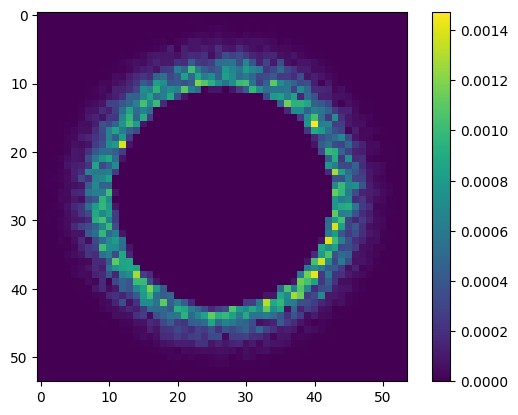

In [479]:
data = np.load(r"I:\Geoparticle-simulation\result_compressedfield\test\sate_data\exp_bins=54.npy")
plt.imshow(data[-1][300])
plt.colorbar()
# np.nanmax(data)

(10, 494, 54, 54)
(9, 494, 4)
30.024957707088465
max running time


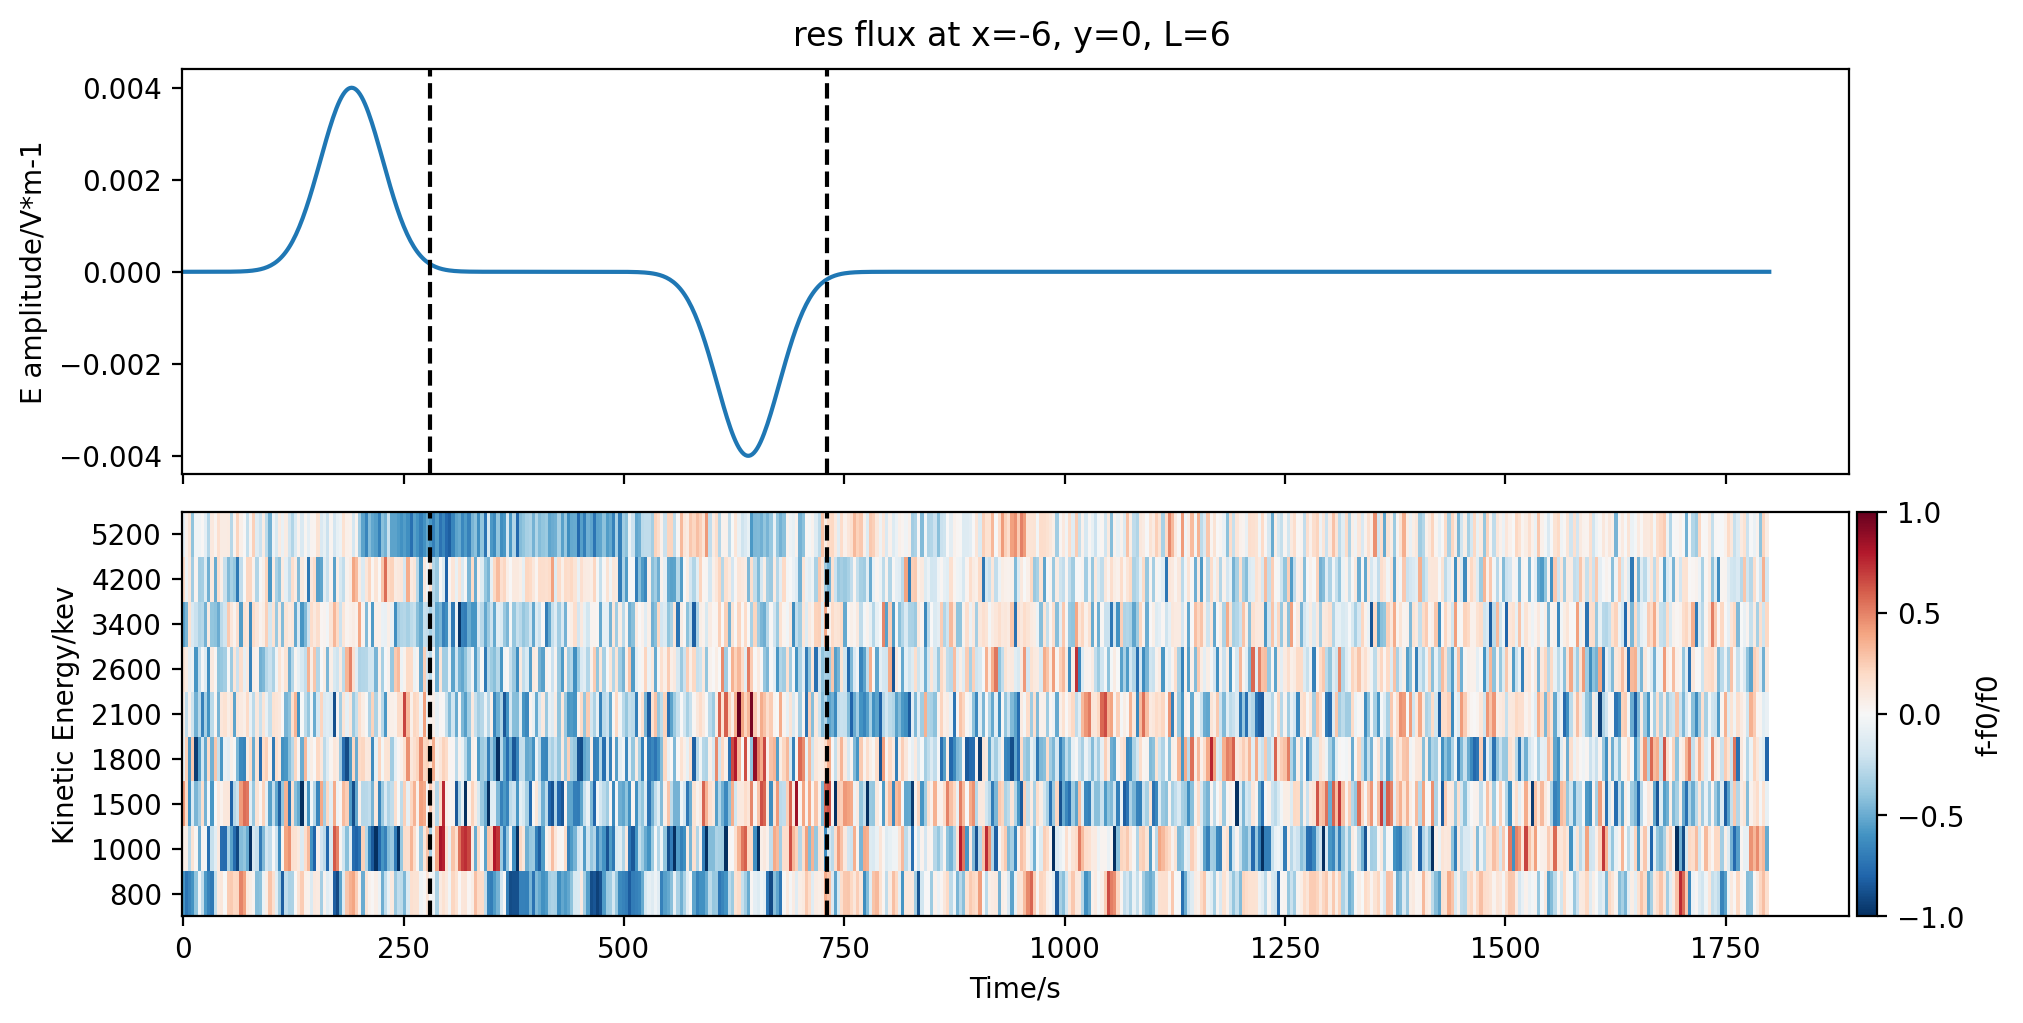

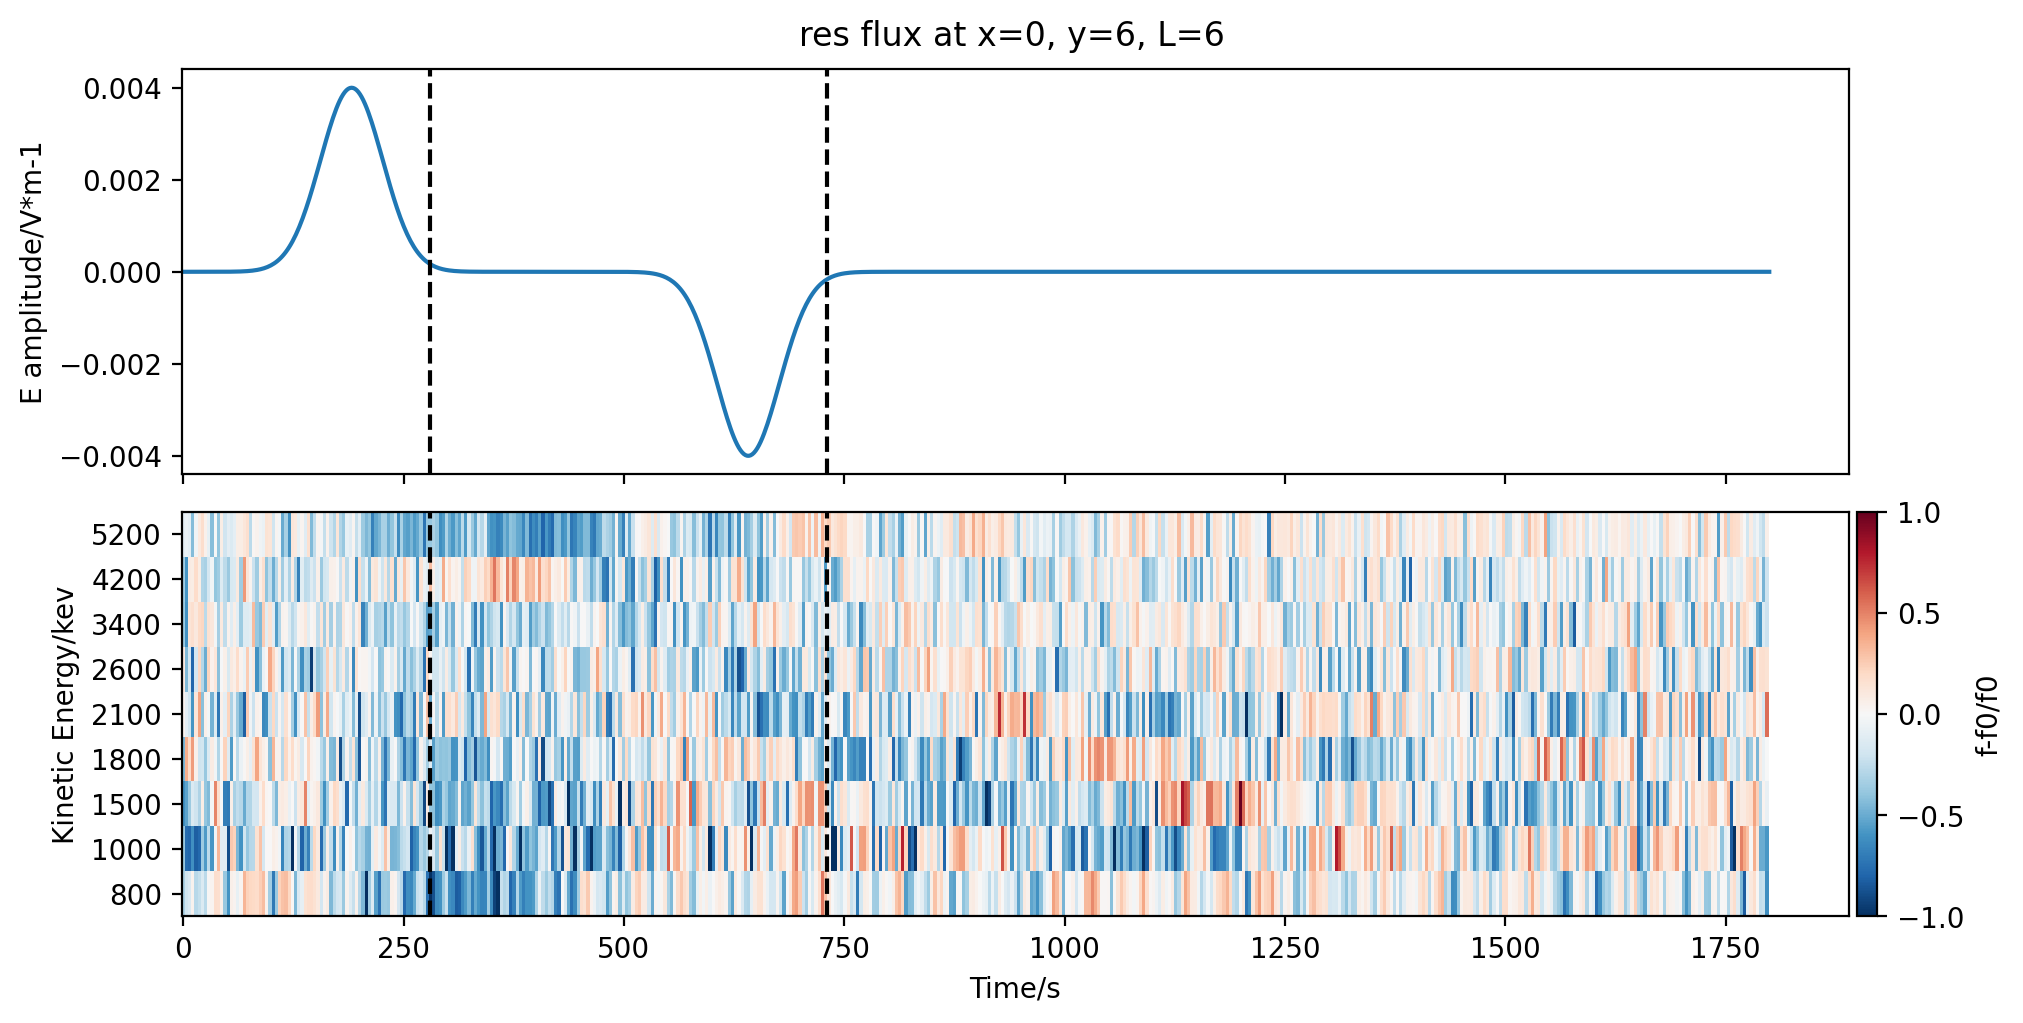

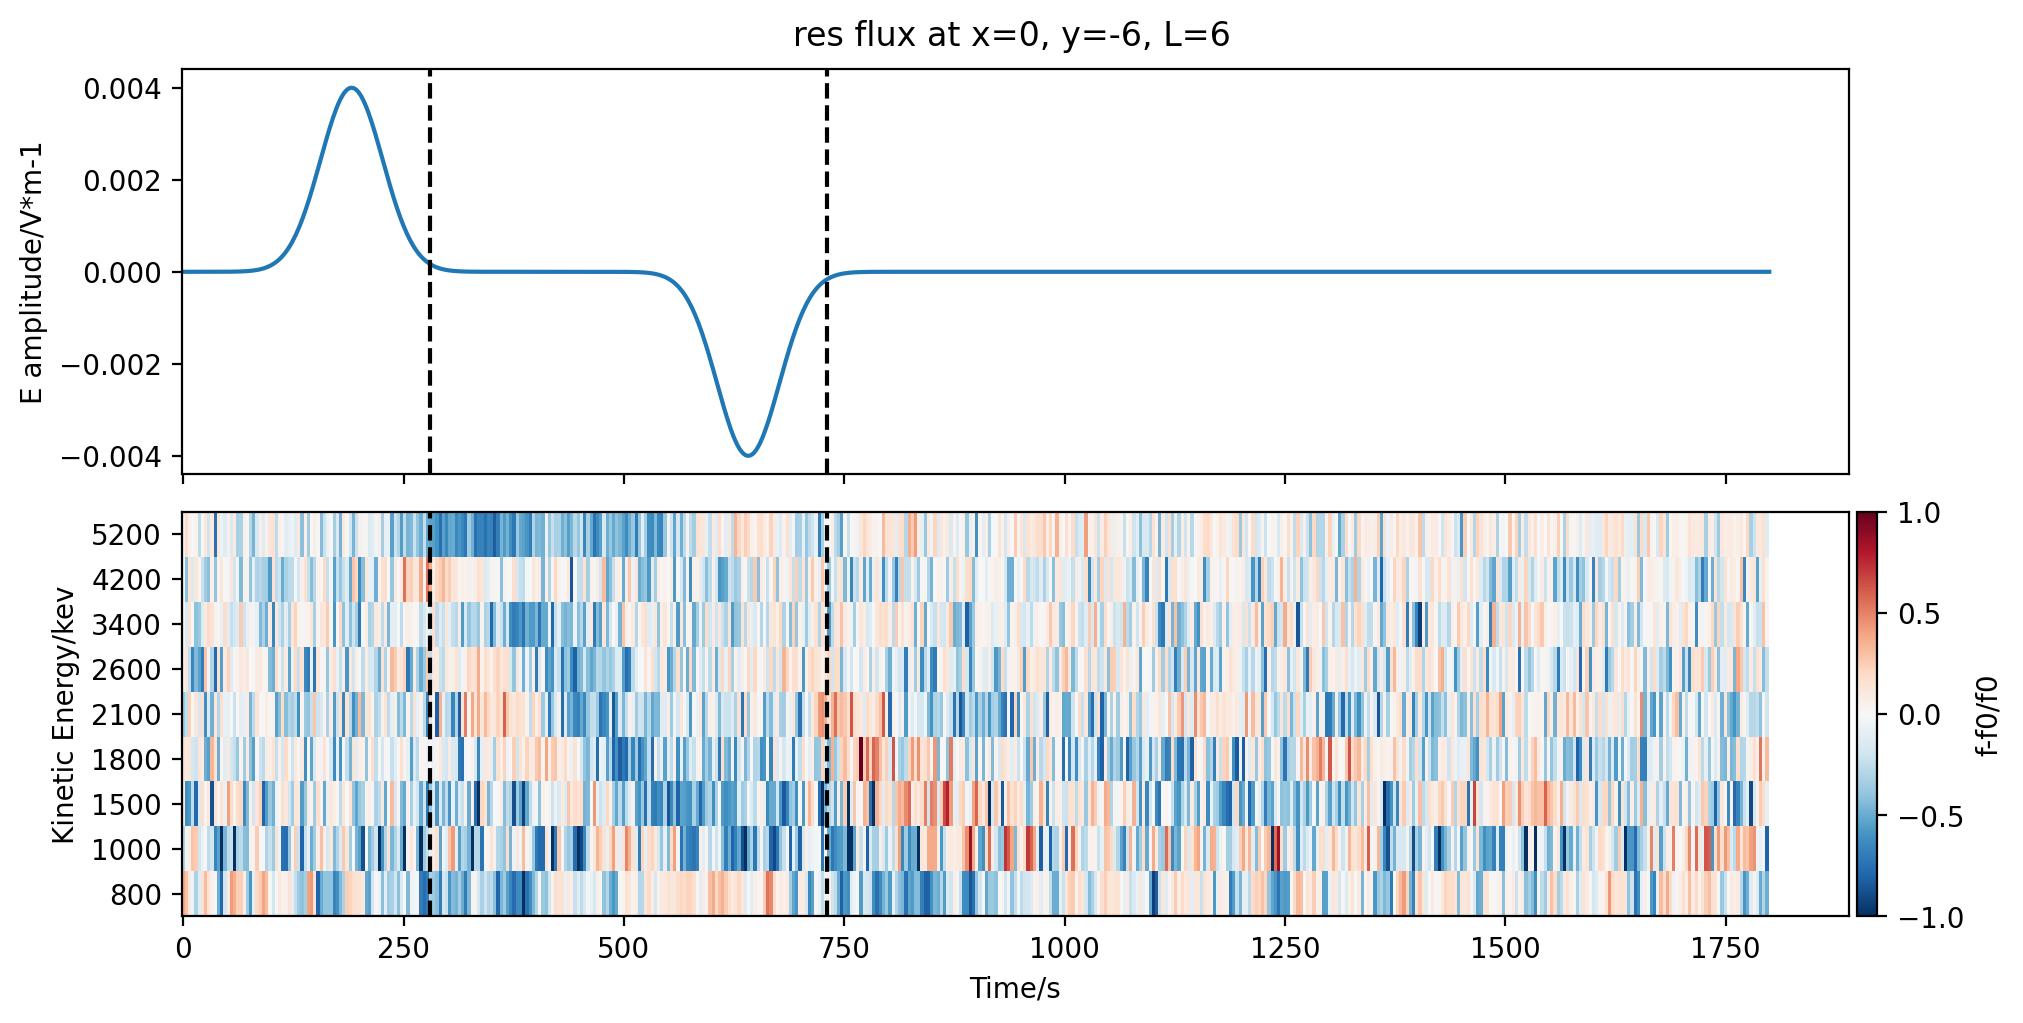

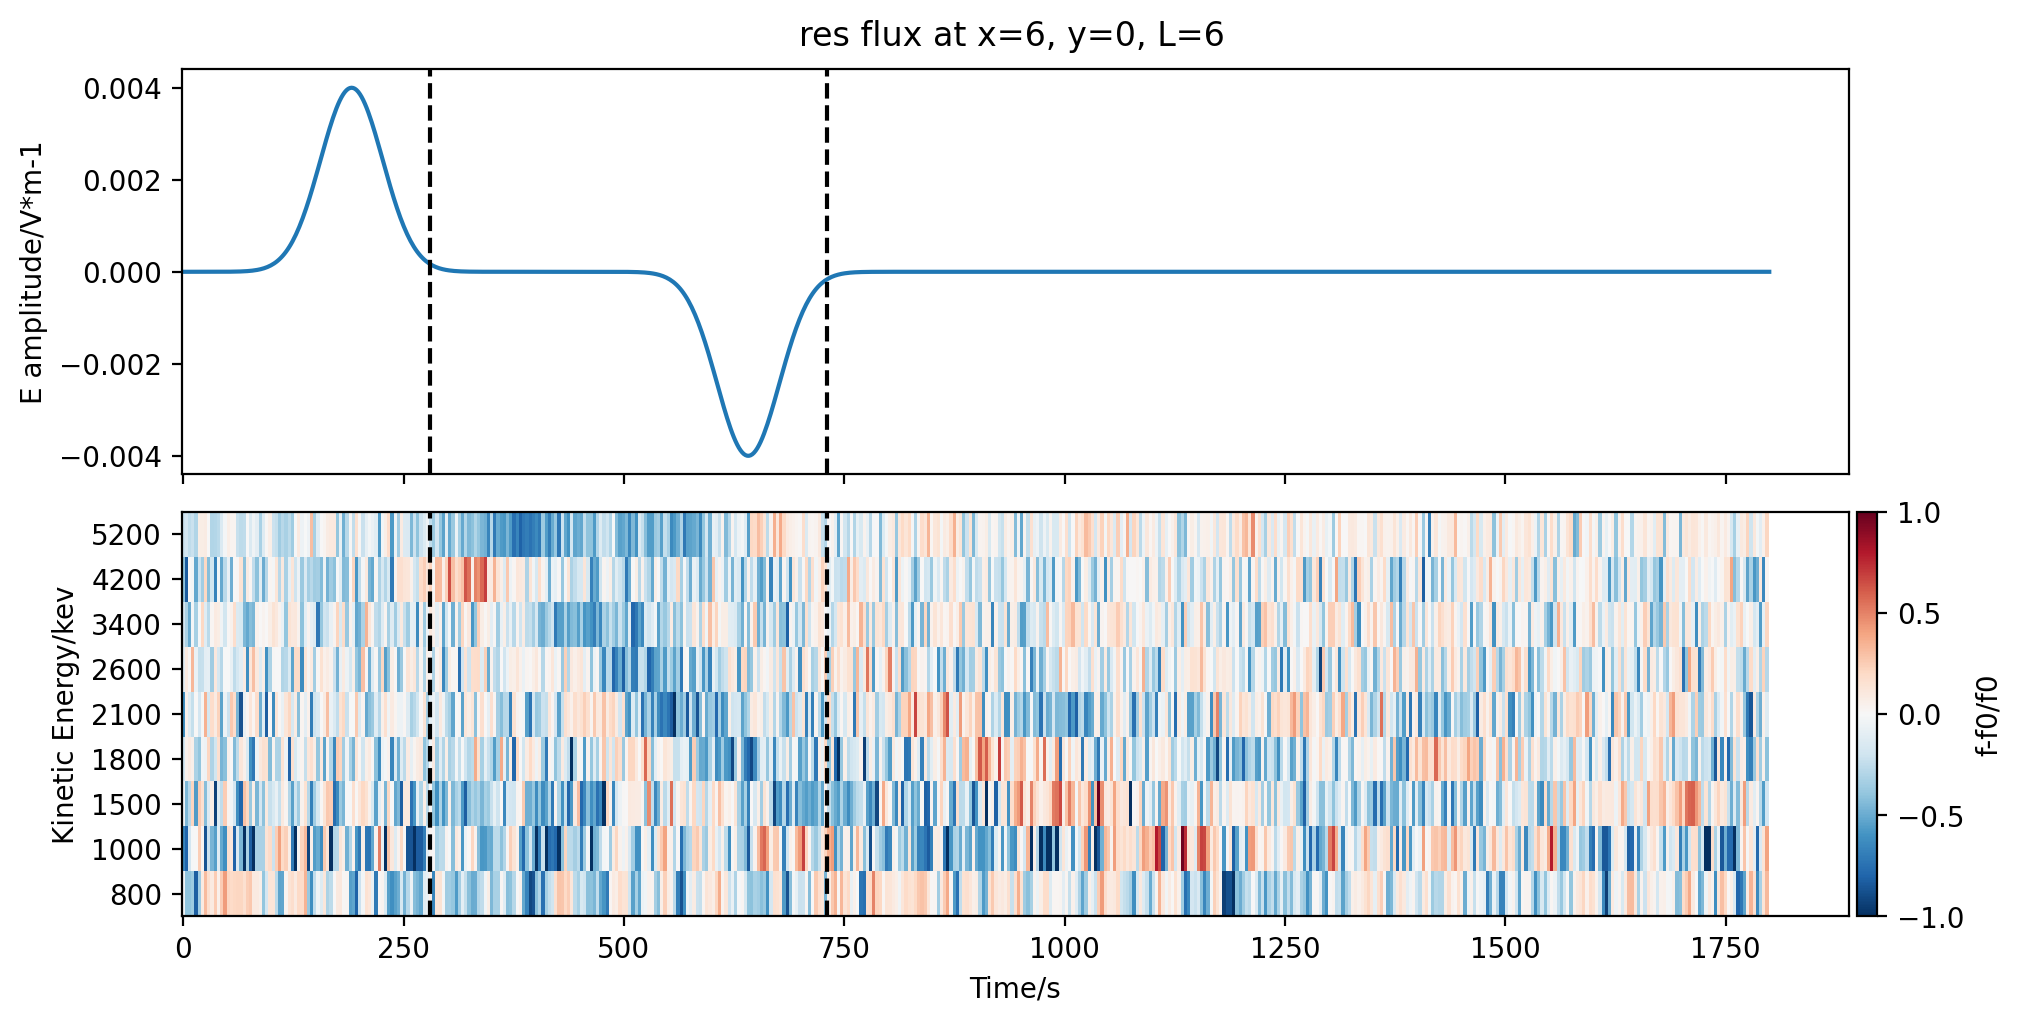

In [497]:
# 绘制 residual flux
L = 6
KEcs = [800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]
# t, emag = pulse_observe(L=L)
bins = 54
result_name = "result_compressedfield"
subfolder_name = "test"
data = np.load("./{}\{}\sate_data/exp_bins={}.npy".format(result_name, subfolder_name, bins))
print(np.shape(data))

std_file = r"./std_files/std_file.csv"
df = pd.read_csv(std_file)
times = df[["time(sec)"]].to_numpy().squeeze()

# def get_number(path):
#     file_name = os.path.basename(path)
#     match = re.search(r'(\d+.\d+).csv', file_name)
#     if match:
#         return float(match.group(1))
#     else:
#         return 0
# files = glob.glob("./{}/{}doubleguass2_process2_time/1000.0/*.csv".format(result_name, result_name))
# sate_times = np.sort([np.round(get_number(file), 4) for file in files])

# 使用最小值和最大值来确定edges
xedges = np.linspace(-6.75, 6.75, bins + 1)
yedges = np.linspace(-6.75, 6.75, bins + 1)
xpoint = [-L, 0, 0, L]
ypoint = [0, L, -L, 0]
values_sum = []
for j in range(len(KEcs)):
    values_list = []
    for i in range(len(times)):
        values = []
        for k in range(len(xpoint)):
            diff = np.abs(xedges - xpoint[k])
            min_idx = np.argmin(diff)
            diff = np.abs(yedges - ypoint[k])
            min_idy = np.argmin(diff)
            value = (data[j, i, min_idy, min_idx] + data[j, i, min_idy-1, min_idx-1]) / 2
            values.append(value)
        values_list.append(values)
    values_sum.append(values_list)
values_sum = np.array(values_sum)
print(np.shape(values_sum))

X, Y = np.meshgrid(times, range(len(KEcs)))

t_pulse, e_pulse, b = pulse_observe(L, pulse_width=0.5e7, pulse_velocity=1e5, rebound_radio=0)
for k in range(4):
    loc_data = values_sum[:,:,k]
    initial_value = np.mean(loc_data[:,:], axis=1,keepdims=True)
    res_flux = (loc_data / initial_value - np.ones_like(loc_data))

    # 将大于0的部分归一化
    mask = res_flux > 0
    positive_res = res_flux[mask]
    min_val = positive_res.min()
    max_val = positive_res.max()
    if max_val > min_val:
        res_flux[mask] = (res_flux[mask] - min_val) / (max_val - min_val)


    fig, axs = plt.subplots(2,1,dpi=200, figsize=(10,5), sharex=True, gridspec_kw={'hspace': 0}, layout='constrained')
    axs[0].plot(t_pulse, e_pulse)
    axs[0].set_ylabel("E amplitude/V*m-1")
    cax = axs[1].pcolormesh(X, Y, res_flux, cmap="RdBu_r", vmax=1, vmin=-1)
    axs[1].set_xlabel("Time/s")
    axs[1].set_ylabel("Kinetic Energy/kev")
    axs[1].set_yticks(range(len(KEcs)))
    axs[1].set_yticklabels(KEcs)
    cbar = fig.colorbar(cax, ax=axs[1], orientation='vertical', pad=0.005)
    cbar.set_label('f-f0/f0')
    for ax in axs:
        ax.axvline(x=280, color='black', linestyle='--')
        ax.axvline(x=730, color='black', linestyle='--')
    fig.suptitle("res flux at x={}, y={}, L={}".format(xpoint[k], ypoint[k], L))
    if not os.path.exists("./{}/{}/res_flux".format(result_name, subfolder_name,)):
        os.makedirs("./{}/{}/res_flux".format(result_name, subfolder_name, ))
    fig.savefig("./{}/{}/res_flux/bins={}_exp_res_flux_x={}_y={}.png".format(result_name, subfolder_name, bins, xpoint[k], ypoint[k]))


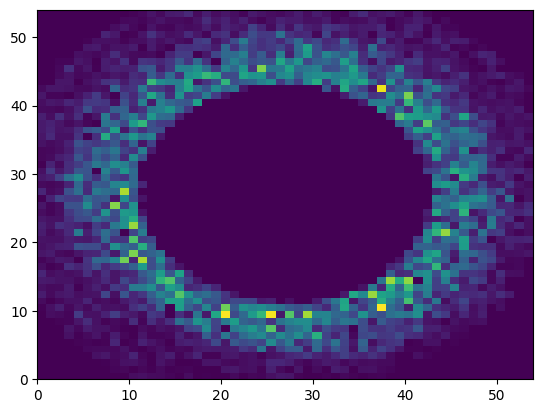

In [166]:
plt.pcolor(data[0, 200, :, :])

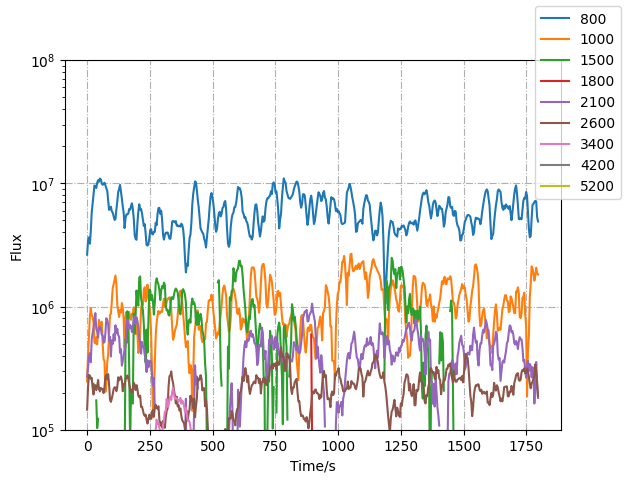

In [167]:
fig, ax = plt.subplots()
values_sum_fix = values_sum.copy()
for i in range(len(KEcs)):
    values_sum_fix_i = np.convolve(values_sum_fix[:,:,-1][i], np.ones(5)/5, mode='same')
    values_sum_fix_i[values_sum_fix_i<1] = np.nan
    ax.plot(times, values_sum_fix_i, label="{}".format(KEcs[i], linewidth=1))

ax.set_ylim(1e5, 1e8)
ax.set_yscale("log")
ax.set_xlabel("Time/s")
ax.set_ylabel("Flux")
ax.grid(linestyle="-.")
fig.legend()

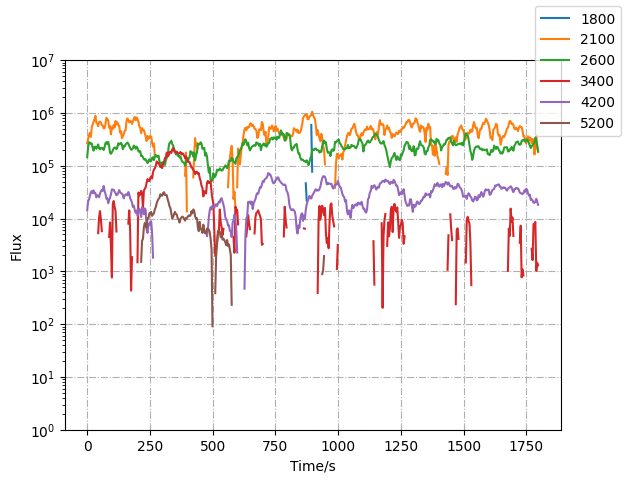

In [168]:
fig, ax = plt.subplots()
values_sum_fix = values_sum.copy()
for i in range(3, len(KEcs)):
    values_sum_fix_i = np.convolve(values_sum_fix[:,:,-1][i], np.ones(5)/5, mode='same')
    values_sum_fix_i[values_sum_fix_i<1] = np.nan
    ax.plot(times, values_sum_fix_i, label="{}".format(KEcs[i], linewidth=1))

ax.set_ylim(1e0, 1e7)
ax.set_yscale("log")
ax.set_xlabel("Time/s")
ax.set_ylabel("Flux")
ax.grid(linestyle="-.")
fig.legend()

In [ ]:
# gif绘制全球通量图
from matplotlib.colors import LogNorm
import re 



result_name = "result_variedvpulse"
bins = 54
KEcs = [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]
data = np.load("./{}/sate_data/doubleguass_bins={}.npy".format(result_name, bins))
for KEc in KEcs:
    step = 4
    axislimit = 8

    # std_file = r"\\172.17.190.20\home\particlesimulation\pulse_simulation\result\KEc=1800\L=5.0\E=1800_L=5.0_PHI=0.csv"
    std_file = "./std_files/std_file.csv"
    df = pd.read_csv(std_file)
    times = df["time(sec)"].values

    time = times[0]
    X = []
    Y = []
    weights = []
    fig, ax = plt.subplots()
    heatmap, xedges, yedges = np.histogram2d(X, Y, bins=(bins, bins), weights=weights)
    im = ax.imshow(heatmap, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='jet', norm=LogNorm(vmin=1e0, vmax=1e9))
    cbar = fig.colorbar(im)
    cbar.locator = ticker.LogLocator()
    cbar.formatter = ticker.LogFormatterSciNotation() 
    cbar.update_ticks()
    # plt.colorbar(label='Flux')  # 添加颜色条，表示数据点个数
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(-axislimit, axislimit)
    ax.set_ylim(-axislimit, axislimit)

    result_name = "result_variedvpulse"
    files = glob.glob("./{}/{}doubleguass2_process2_time/{:.1f}/*.csv".format(result_name, result_name, KEc))
    def get_number(path):
        file_name = os.path.basename(path)
        match = re.search(r'(\d+.\d+).csv', file_name)
        if match:
            return float(match.group(1))
        else:
            return 0
    files.sort(key=get_number)
    files_times = [np.float64(re.search(r'(\d+.\d+).csv', f).group(1)) for f in files]

    frames = int((len(files_times) - 1)/step)
    def update(frame):
        i = frame*step

        # if t1[i] <= p1_t[-1]:
        #     cmesh = ax.pcolormesh(X_m[:,:,i], Y_m[:,:,i], Epulse_magnitude1[:, :, i], cmap='coolwarm', vmin= vmin, vmax=vmax, zorder=1, alpha=0.5)
        # else:
        #     cmesh = ax.pcolormesh(X_m[:,:,i], Y_m[:,:,i], Epulse_magnitude2[:, :, i], cmap='coolwarm', vmin= vmin, vmax=vmax, zorder=1, alpha=0.5)
        
        file = files[i]
        t = files_times[i]
        X = []
        Y = []
        weights = []
        df = pd.read_csv(file)
        X = df["x"]
        X = df["x"]
        Y = df["y"]
        df['flux'] = df['flux'].apply(lambda x: 0 if np.isnan(x) else x)
        weights = df['flux'] 

        # 确定bin数
        bins = 52
        # 使用最小值和最大值来确定edges
        xedges = np.linspace(-6.5, 6.5, bins + 1)
        yedges = np.linspace(-6.5, 6.5, bins + 1)

        heatmap, xedges, yedges = np.histogram2d(X, Y, bins=(xedges, yedges), weights=weights)
        im = ax.imshow(heatmap, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='jet', norm=LogNorm(vmin=1e0, vmax=1e9))
        # im.set_array(heatmap)
        ax.set_title('Heatmap of {}KeV electron amounts at {:.0f}s'.format(KEc, t))
        ax.set_xlim(-axislimit, axislimit)
        ax.set_ylim(-axislimit, axislimit)

        return [im]

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=5, blit=True)
    if not os.path.exists("./{}/gifs/".format(result_name)):
        os.makedirs("./{}/gifs/".format(result_name))
    ani.save('./{}/gifs/random_electron_flux_heatmap_{}kev.gif'.format(result_name, KEc), writer='imagemagick')  # 使用imagemagick写入GIF

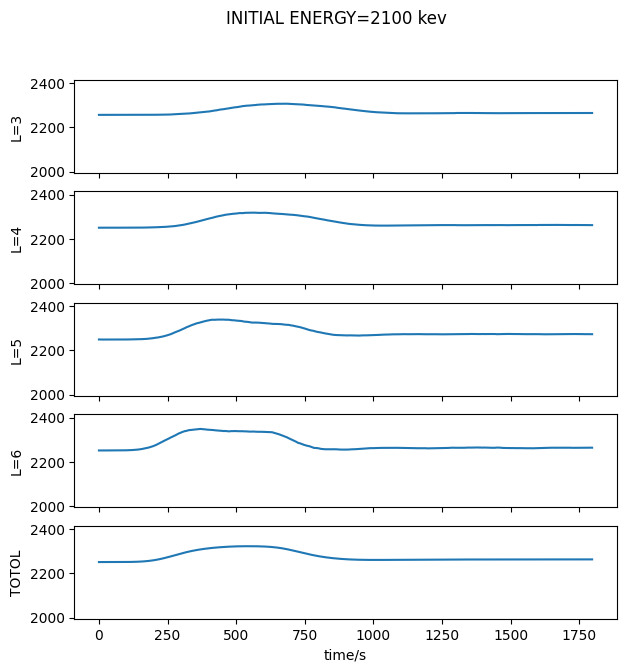

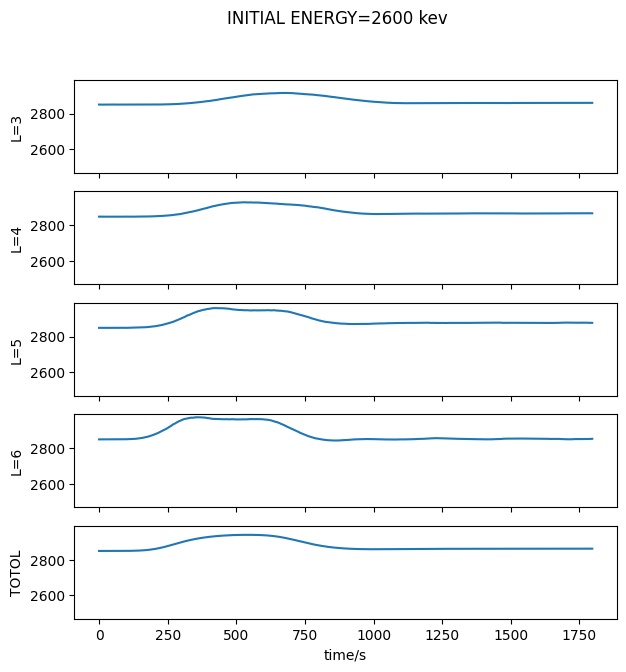

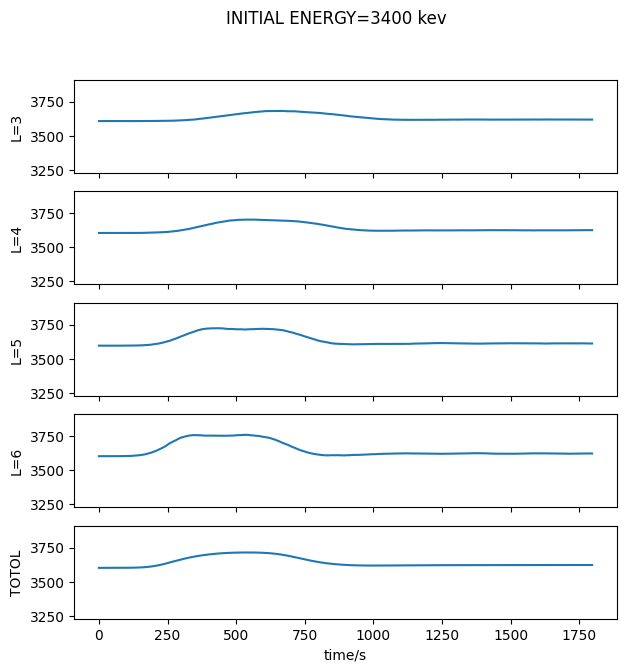

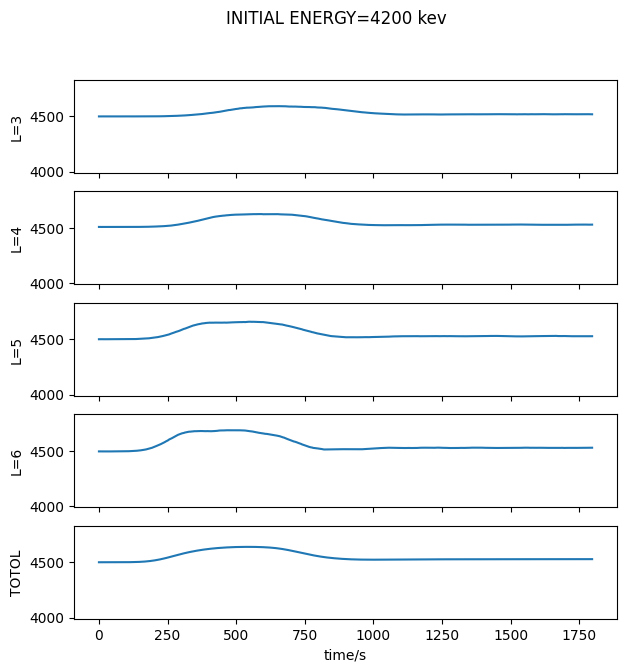

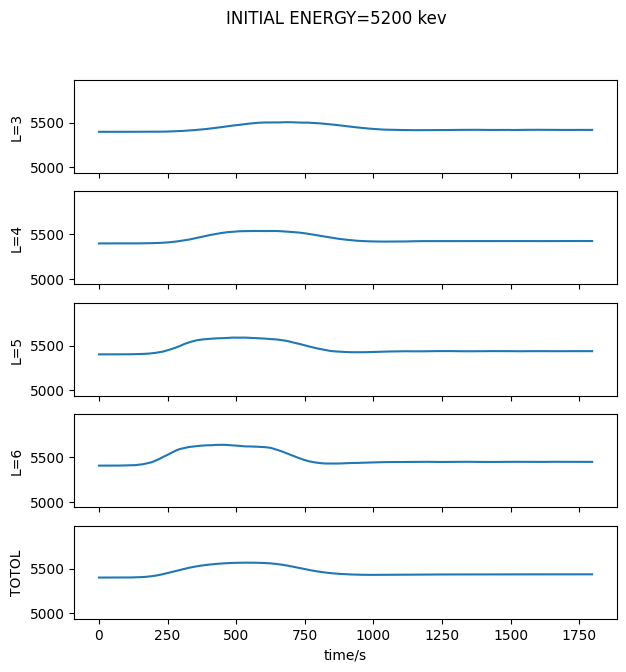

In [72]:
# 每个L值上的平均能量变化（没什么意义）
KEcs = [800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]

# for L in Ls:
sate_data_list = []
sate_data_time_list = []
for KEc in KEcs:
    print(KEc)
    Sate_data = []

    # std_file = r"\\172.17.190.20\home\particlesimulation\pulse_simulation\result\KEc=1800\L=5.0\E=1800_L=5.0_PHI=0.csv"
    std_file = r"./std_files/std_file.csv"
    df = pd.read_csv(std_file)
    times = df[["time(sec)"]].to_numpy()

    # frames = range(int(len(times)))
    # frames = len(times) - 2
    # frames = 20

    result_name = "result_variedvpulse"
    # files = glob.glob("./result_random_process2_time/{:.1f}/*.csv".format(KEc))
    files = glob.glob("./{}/{}doubleguass2_process2_time_fixkec/{:.1f}/*.csv".format(result_name, result_name, KEc))
    def get_number(path):
        file_name = os.path.basename(path)
        match = re.search(r'(\d+.\d+).csv', file_name)
        if match:
            return float(match.group(1))
        else:
            return 0
    files.sort(key=get_number) # 文件顺序按照时间顺序排列
    frames = len(files)
    files_times = [np.float64(re.search(r'(\d+.\d+).csv', f).group(1)) for f in files]
    sate_data_time_list.append(files_times)

    frames = len(files)
    mean_kec_list = []
    for i in range(frames):
        file = files[i]
        df = pd.read_csv(file)
        mean_wtot = df['wtot'].mean()
        mean_kec = (mean_wtot/C.elementary_charge/1e6 - 0.511) * 1000
        df["L"] = np.sqrt(df["x"] ** 2 + df["y"] ** 2)
        L_range = [3,4,5,6]
        mean_kecs = list()
        for l in L_range:
            df_temp = df.loc[(df["L"]>l-0.5) & (df["L"]<l+0.5) ,:]
            mean_wtot_temp = df_temp['wtot'].mean()
            mean_kec_temp = (mean_wtot_temp/C.elementary_charge/1e6 - 0.511) * 1000
            mean_kecs.append(mean_kec_temp)
        mean_kecs.append(mean_kec)
        mean_kec_list.append(mean_kecs)
    np.save("./{}/sate_data/mean_kec_{}.npy".format(result_name, KEc), np.array(mean_kec_list))

for KEc in KEcs:
    mean_kec = np.load("./{}/sate_data/mean_kec_{}.npy".format(result_name, KEc))
    fig, axs = plt.subplots(5, 1, dpi=100, figsize=(7,7), sharex=True)
    axs = axs.flatten()
    ylabels = ['L=3', 'L=4', 'L=5', 'L=6', 'TOTOL']
    for i in range(np.shape(mean_kec)[1]):
        axs[i].plot(files_times, mean_kec[:, i])
        axs[i].set_ylim(KEc*0.95, KEc*1.15)
        axs[i].set_ylabel("{}".format(ylabels[i]))
    axs[-1].set_xlabel("time/s")
    fig.suptitle("INITIAL ENERGY={} kev".format(KEc))
    fig.savefig("./figures/average_energy_{}.png".format(KEc))

In [8]:
# 粒子散点能量变化和电场变化gif
KEcs = [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]
# KEcs = [500]


for KEc in KEcs:
    print(KEc)
    Sate_data = []

    # std_file = r"\\172.17.190.20\home\particlesimulation\pulse_simulation\result\KEc=1800\L=5.0\E=1800_L=5.0_PHI=0.csv"
    std_file = r"./std_files/std_file.csv"
    df = pd.read_csv(std_file)
    times = df[["time(sec)"]].to_numpy().squeeze()

    result_name = "result_simpliest"
    subfolder_name = "doublegaussfullfit_exp"
    frames = len(times)
    kec_list = []

    df = pd.read_csv("./{}/{}_final/{:.1f}.csv".format(result_name, result_name, KEc))
    for i in range(frames):
        t = times[i]
        df_temp = df.loc[np.round(df["time(sec)"],2)==np.round(t,2), :]
        x = df_temp["x"]
        y = df_temp["y"]
        kec = (df_temp["wtot"]/C.elementary_charge/1e6 - 0.511) * 1000
        kec_list.append([x, y, kec])
    del df_temp
    np.save("./{}/{}/sate_data/kec_{}.npy".format(result_name, subfolder_name, KEc), np.array(kec_list))

500
800
1000
1500
1800
2100
2600
3400
4200
5200


In [ ]:
KEcs = [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]
# KEcs = [500]

result_name = "result_rebound"
std_file = r"./std_files/std_file.csv"
df = pd.read_csv(std_file)
times = df[["time(sec)"]].to_numpy()

pulse_width = 3e7
pulse_velocity = 1
# 绘制整个区域的的电场
input_parameters = {
    "xmu": -1, # -1 for electron, 1 for proton
    "IOPT": 1, # = kp + 1
    "raddist0": 6, # initial L
    "longi0": 0, # intital phi
    'pa':90, # pitch angle
    "KEc0": 3400, # initial kinetic energy /KeV
    "timedir": 1,
    "Tout": 60,
    "Dmin": 0,
    "pulse_flag": 1, 
    "tmax": 30, # maximum simulation time /min
} 
pulse_parameters = {
    "phi0":0,
    "E0": 2.5, # 5mV/m
    "c0":1,
    "c1":1,
    "c2":0.8,
    "c3":1,
    "p":1,
    "va":50000,
    "ri":0.6371E8 * 1.5, # m ri/vpulse determine the arrival time of pusle
    "ti":100,
    "di":pulse_width, # width of the pusle
    "rd":2.06, # pulse rebound at rd/2 Re
    "vpulse": pulse_velocity, # m/s
    "duration" : 450 # s 
}
p1 = prt_sim(input_parameters, pulse_parameters, {})
p1_r, p1_t, p1_wtot = p1.prt_sim()    
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
Xm, Ym, Tm = np.meshgrid(x, y, p1_t, indexing='ij')
Zm = np.zeros_like(Xm)
pulse = p1.pulse_fields(1, Tm, Xm, Ym, Zm)
Epulse = pulse[0]
Epulse_magnitude = np.sqrt(Epulse[0]**2 + Epulse[1]**2 + Epulse[2]**2)

# 确定电场方向与位置向量的关系来区分正负电场 
checker = np.zeros_like(Epulse_magnitude)
for index, value in np.ndenumerate(Epulse):
    xindex, yindex, tindex = index[-3], index[-2], index[-1]
    Ex = Epulse[0, xindex, yindex, tindex]
    Ey = Epulse[1, xindex, yindex, tindex]
    x = Xm[xindex, yindex, tindex]
    y = Ym[xindex, yindex, tindex]
    E = np.array([Ex, Ey])
    pos = np.array([x, y])
    cross_product = E[0] * pos[1] - E[1] * pos[0]
    if cross_product < 0 :
        checker[xindex, yindex, tindex] = -1 # 逆时针，即电场方向与电子漂移同向
    elif cross_product > 0:
        checker[xindex, yindex, tindex] = 1 # 顺时针，反向
    else:
        checker[xindex, yindex, tindex] = 0
Epulse_magnitude = checker * Epulse_magnitude


for KEc in KEcs:
    step = 5
    frames = int((len(times) - 1)/step)
    kec_list = np.load("./{}/sate_data/kec_{}.npy".format(result_name, KEc))
    fig, ax = plt.subplots(1,1)
    scatter = ax.scatter(kec_list[0, 0, :], kec_list[0,1,:], c=kec_list[0,2,:]-kec_list[0,2,:], vmin=100, vmax=-100, s=1, cmap='bwr', zorder=2)
    ax.figure.colorbar(scatter, ax=ax, label='Energy variation(KeV)')
    ax.set_xlim(-7.5, 7.5)
    ax.set_ylim(-7.5, 7.5)
    ax.set_aspect("equal")
    # 添加地球
    left_half = patches.Wedge((0, 0), 1, 90, 270, color='black', zorder=3)
    right_half = patches.Wedge((0, 0), 1, 270, 90, color='white', zorder=3)
    ax.add_patch(left_half)
    ax.add_patch(right_half)
    

    cmesh = ax.pcolormesh(Xm[:,:,0], Ym[:,:,0], Epulse_magnitude[:, :, 0], cmap=cm.coolwarm, vmin=-1e-2, vmax=1e-2, zorder=1)
    cbar = fig.colorbar(cmesh, label="Efield(V/m)", location="left")
    
    # 使用科学计数法格式化颜色条
    cbar.formatter = ticker.ScalarFormatter()
    cbar.formatter.set_powerlimits((0, 0))  # 强制使用科学计数法
    cbar.update_ticks()  # 更新刻度以应用新格式

    
    def update(frame):

        i = frame*step
        t = times[i].squeeze()
        X = kec_list[i, 0, :]
        Y = kec_list[i, 1, :]
        c = kec_list[i, 2, :]
 
        scatter.set_offsets(np.column_stack((kec_list[i, 0, :], kec_list[i, 1, :])))
        scatter.set_array(kec_list[i, 2, :]-kec_list[0,2,:])
        # im.set_array(heatmap)
        ax.set_title('scatter of {}KeV electron at {:.0f}s'.format(KEc, t))
        ax.set_xlim(-7.5, 7.5)
        ax.set_ylim(-7.5, 7.5)

        k = int(np.shape(Epulse_magnitude)[-1] / frames * frame)
        cmesh = ax.pcolormesh(Xm[:,:,k], Ym[:,:,k], Epulse_magnitude[:, :, k], cmap='coolwarm', vmin= -1e-2, vmax=1e-2, zorder=1)
  
        return cmesh,

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=5, blit=True)
    if not os.path.exists("./{}/gifs/".format(result_name)):
        os.makedirs("./{}/gifs/".format(result_name))
    ani.save('./{}/gifs/scatter_fixed_{}kev.gif'.format(result_name, KEc), writer='imagemagick')  # 使用imagemagick写入GIF

In [89]:
input_parameters = {
    "xmu": -1, # -1 for electron, 1 for proton
    "IOPT": 1, # = kp + 1
    "raddist0": 6, # initial L
    "longi0": 0, # intital phi
    'pa':90, # pitch angle
    "KEc0": 4000, # initial kinetic energy /KeV
    "timedir": 1,
    "Tout": 60,
    "Dmin": 0,
    "pulse_flag": 0, 
    "tmax": 190/60, # maximum simulation time /min
} 
pulse_parameters = {
    "phi0":0,
    "E0": 2, # 5mV/m
    "c0":1,
    "c1":1,
    "c2":0,
    "c3":1,
    "p":1,
    "va":50000,
    "ri":0.6371E8 * 1.5, # m ri/vpulse determine the arrival time of pusle
    "ti":100,
    "di":3e7, # width of the pusle
    "rd":2.06, # pulse rebound at rd/2 Re
    "vpulse": 1, # m/s
    "duration" : 450 # s 
}
p1 = prt_sim(input_parameters, pulse_parameters, {})
p1_r, p1_t, p1_wtot = p1.prt_sim()


3.169311412309747
max running time


30.024957707088465
max running time


MovieWriter imagemagick unavailable; using Pillow instead.


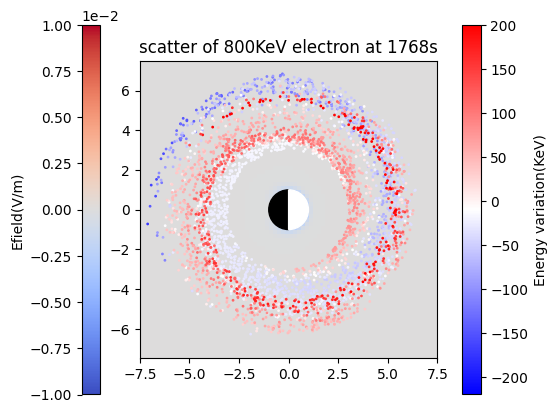

In [19]:
KEcs = [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]
KEcs = [800]

result_name = "result_simpliest"
subfolder_name = "doublegaussfullfit_exp"
std_file = r"./std_files/std_file.csv"
df = pd.read_csv(std_file)
times = df[["time(sec)"]].to_numpy()

pulse_width = 2e7
pulse_velocity = 1
# 绘制整个区域的的电场
input_parameters = {
    "xmu": -1, # -1 for electron, 1 for proton
    "IOPT": 1, # = kp + 1
    "raddist0": 6, # initial L
    "longi0": 0, # intital phi
    'pa':90, # pitch angle
    "KEc0": 3400, # initial kinetic energy /KeV
    "timedir": 1,
    "Tout": 60,
    "Dmin": 0,
    "pulse_flag": 1, 
    "tmax": 30, # maximum simulation time /min
} 
pulse_parameters = {
    "phi0":0,
    "E0": 2.5, # 5mV/m
    "c0":1,
    "c1":1,
    "c2":0,
    "c3":1,
    "p":1,
    "va":50000,
    "ri":0.6371E8 * 1.5, # m ri/vpulse determine the arrival time of pusle
    "ti":100,
    "di":pulse_width, # width of the pusle
    "rd":2.06, # pulse rebound at rd/2 Re
    "vpulse": pulse_velocity, # m/s
    "duration" : 450 # s 
}
p1 = prt_sim(input_parameters, pulse_parameters, {})
p1_r, p1_t, p1_wtot = p1.prt_sim()    
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
Xm, Ym, Tm = np.meshgrid(x, y, p1_t, indexing='ij')
Zm = np.zeros_like(Xm)
pulse = p1.pulse_fields(1, Tm, Xm, Ym, Zm)
Epulse = pulse[0]
Epulse_magnitude = np.sqrt(Epulse[0]**2 + Epulse[1]**2 + Epulse[2]**2)

# 确定电场方向与位置向量的关系来区分正负电场 
checker = np.zeros_like(Epulse_magnitude)
for index, value in np.ndenumerate(Epulse):
    xindex, yindex, tindex = index[-3], index[-2], index[-1]
    Ex = Epulse[0, xindex, yindex, tindex]
    Ey = Epulse[1, xindex, yindex, tindex]
    x = Xm[xindex, yindex, tindex]
    y = Ym[xindex, yindex, tindex]
    E = np.array([Ex, Ey])
    pos = np.array([x, y])
    cross_product = E[0] * pos[1] - E[1] * pos[0]
    if cross_product < 0 :
        checker[xindex, yindex, tindex] = -1 # 逆时针，即电场方向与电子漂移同向
    elif cross_product > 0:
        checker[xindex, yindex, tindex] = 1 # 顺时针，反向
    else:
        checker[xindex, yindex, tindex] = 0
Epulse_magnitude = checker * Epulse_magnitude


for KEc in KEcs:
    step = 5
    frames = int((len(times) - 1)/step)
    kec_list = np.load("./{}/sate_data/kec_{}.npy".format(result_name, KEc))
    fig, ax = plt.subplots(1,1)
    scatter = ax.scatter(kec_list[0, 0, :], kec_list[0,1,:], c=kec_list[0,2,:]-kec_list[0,2,:], vmin=200, vmax=-200, s=1, cmap='bwr', zorder=2)
    ax.figure.colorbar(scatter, ax=ax, label='Energy variation(KeV)')
    ax.set_xlim(-7.5, 7.5)
    ax.set_ylim(-7.5, 7.5)
    ax.set_aspect("equal")
    # 添加地球
    left_half = patches.Wedge((0, 0), 1, 90, 270, color='black', zorder=3)
    right_half = patches.Wedge((0, 0), 1, 270, 90, color='white', zorder=3)
    ax.add_patch(left_half)
    ax.add_patch(right_half)
    

    cmesh = ax.pcolormesh(Xm[:,:,0], Ym[:,:,0], Epulse_magnitude[:, :, 0], cmap=cm.coolwarm, vmin=-1e-2, vmax=1e-2, zorder=1)
    cbar = fig.colorbar(cmesh, label="Efield(V/m)", location="left")
    
    # 使用科学计数法格式化颜色条
    cbar.formatter = ticker.ScalarFormatter()
    cbar.formatter.set_powerlimits((0, 0))  # 强制使用科学计数法
    cbar.update_ticks()  # 更新刻度以应用新格式

    
    def update(frame):

        i = frame*step
        t = times[i].squeeze()
        X = kec_list[i, 0, :]
        Y = kec_list[i, 1, :]
        c = kec_list[i, 2, :]
 
        scatter.set_offsets(np.column_stack((kec_list[i, 0, :], kec_list[i, 1, :])))
        scatter.set_array(kec_list[i, 2, :]-kec_list[0,2,:])
        # im.set_array(heatmap)
        ax.set_title('scatter of {}KeV electron at {:.0f}s'.format(KEc, t))
        ax.set_xlim(-7.5, 7.5)
        ax.set_ylim(-7.5, 7.5)

        k = int(np.shape(Epulse_magnitude)[-1] / frames * frame)
        cmesh = ax.pcolormesh(Xm[:,:,k], Ym[:,:,k], Epulse_magnitude[:, :, k], cmap='coolwarm', vmin= -1e-2, vmax=1e-2, zorder=1)
  
        return cmesh,

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=5, blit=True)
    if not os.path.exists("./{}/{}/gifs/".format(result_name, subfolder_name)):
        os.makedirs("./{}/{}/gifs/".format(result_name, subfolder_name))
    ani.save('./{}/{}/gifs/scatter_fixed_{}kev.gif'.format(result_name, subfolder_name, KEc), writer='imagemagick')  # 使用imagemagick写入GIF

In [ ]:
import os.path

# 绘制某个粒子的能量变化图
result_name = "result_variedvpulse"
KEc = 1800
df = pd.read_csv("./{}/{}_final/{:.1f}.csv".format(result_name, result_name, KEc))
std_file = r"./std_files/std_file.csv"
df_std = pd.read_csv(std_file)
times = df_std[["time(sec)"]].to_numpy().squeeze()

df["r"] = np.sqrt(df["x"]**2 + df["y"]**2)
df['kec'] = (df["wtot"]/C.elementary_charge/1e6 - 0.511) * 1000
case_index = 2000
for case_index in range(10, 2000, 100):
    case_df = pd.DataFrame(columns=df.columns)
    for i in range(len(times)):
        t = times[i]
        df_temp = df.loc[np.round(df["time(sec)"], 2)== np.round(t, 2), :]
        df_temp = df_temp.reset_index(drop=True)
        item = df_temp.loc[case_index, :]
        case_df.loc[i] = item
    case_kec = case_df["kec"].to_numpy()
    fig, ax = plt.subplots()
    ax.plot(times, case_kec)
    ax.set_title("init_kec={} kev, init_x={:.2f}, init_y={:.2f}".format(KEc, case_df.loc[0, "x"], case_df.loc[0, "y"]))
    ax.grid("--")
    ax.set_xlabel("t")
    ax.set_ylabel("Energy/kev")
    ax.set_ylim(case_kec[0]-200, case_kec[0]+200)
    if not os.path.exists("./{}/figures/{}/".format(result_name, KEc)):
        os.makedirs("./{}/figures/{}/".format(result_name, KEc))
    fig.savefig("./{}/figures/{}/{}.png".format(result_name, KEc, [case_df.loc[0, "x"], case_df.loc[0, "y"]]))

In [ ]:
pulse_width = 0.5e7
pulse_velocity = 1e5
# 绘制整个区域的的磁场
input_parameters = {
    "xmu": -1, # -1 for electron, 1 for proton
    "IOPT": 1, # = kp + 1
    "raddist0": 6, # initial L
    "longi0": 0, # intital phi
    'pa':90, # pitch angle
    "KEc0": 3400, # initial kinetic energy /KeV
    "timedir": 1,
    "Tout": 60,
    "Dmin": 0,
    "pulse_flag": 1, 
    "tmax": 30, # maximum simulation time /min
} 
pulse_parameters = {
    "phi0":0,
    "E0": 2, # 5mV/m
    "c0":1,
    "c1":1,
    "c2":0,
    "c3":1,
    "p":1,
    "va":50000,
    "ri":0.6371E8, # m ri/vpulse determine the arrival time of pusle
    "ti":0,
    "di":pulse_width, # width of the pusle
    "rd":1.03, # pulse rebound at rd/2 Re
    "vpulse": pulse_velocity, # m/s
    "duration" : 450 # s 
}
p1 = prt_sim(input_parameters, pulse_parameters, {})
p1_r, p1_t, p1_wtot = p1.prt_sim()    
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
Xm, Ym, Tm = np.meshgrid(x, y, p1_t, indexing='ij')
Zm = np.zeros_like(Xm)
pulse = p1.pulse_fields(1, Tm, Xm, Ym, Zm)
Bpulse = pulse[0]
Bpulse_magnitude = np.sqrt(Bpulse[0]**2 + Bpulse[1]**2 + Bpulse[2]**2)

B_bg = p1.MAG(Tm, 0, Xm, Ym, Zm)

for KEc in KEcs:
    step = 5
    frames = int((len(times) - 1)/step)
    kec_list = np.load("./{}/sate_data/kec_{}.npy".format(result_name, KEc))
    fig, ax = plt.subplots(1,1)
    scatter = ax.scatter(kec_list[0, 0, :], kec_list[0,1,:], c=kec_list[0,2,:]-kec_list[0,2,:], vmin=100, vmax=-100, s=1, cmap='bwr', zorder=2)
    ax.figure.colorbar(scatter, ax=ax, label='Energy variation(KeV)')
    ax.set_xlim(-7.5, 7.5)
    ax.set_ylim(-7.5, 7.5)
    ax.set_aspect("equal")
    # 添加地球
    left_half = patches.Wedge((0, 0), 1, 90, 270, color='black', zorder=3)
    right_half = patches.Wedge((0, 0), 1, 270, 90, color='white', zorder=3)
    ax.add_patch(left_half)
    ax.add_patch(right_half)
    

    cmesh = ax.pcolormesh(Xm[:,:,0], Ym[:,:,0], Epulse_magnitude[:, :, 0], cmap=cm.coolwarm, vmin=-1e-2, vmax=1e-2, zorder=1)
    cbar = fig.colorbar(cmesh, label="Efield(V/m)", location="left")
    
    # 使用科学计数法格式化颜色条
    cbar.formatter = ticker.ScalarFormatter()
    cbar.formatter.set_powerlimits((0, 0))  # 强制使用科学计数法
    cbar.update_ticks()  # 更新刻度以应用新格式

    
    def update(frame):

        i = frame*step
        t = times[i].squeeze()
        X = kec_list[i, 0, :]
        Y = kec_list[i, 1, :]
        c = kec_list[i, 2, :]
 
        scatter.set_offsets(np.column_stack((kec_list[i, 0, :], kec_list[i, 1, :])))
        scatter.set_array(kec_list[i, 2, :]-kec_list[0,2,:])
        # im.set_array(heatmap)
        ax.set_title('scatter of {}KeV electron at {:.0f}s'.format(KEc, t))
        ax.set_xlim(-7.5, 7.5)
        ax.set_ylim(-7.5, 7.5)

        k = int(np.shape(Epulse_magnitude)[-1] / frames * frame)
        cmesh = ax.pcolormesh(Xm[:,:,k], Ym[:,:,k], Epulse_magnitude[:, :, k], cmap='coolwarm', vmin= -1e-2, vmax=1e-2, zorder=1)
  
        return cmesh,

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=5, blit=True)
    if not os.path.exists("./{}/gifs/".format(result_name)):
        os.makedirs("./{}/gifs/".format(result_name))
    ani.save('./{}/gifs/test.gif'.format(result_name, KEc), writer='imagemagick')  # 使用imagemagick写入GIF

30.004364410399827
max running time


MovieWriter imagemagick unavailable; using Pillow instead.


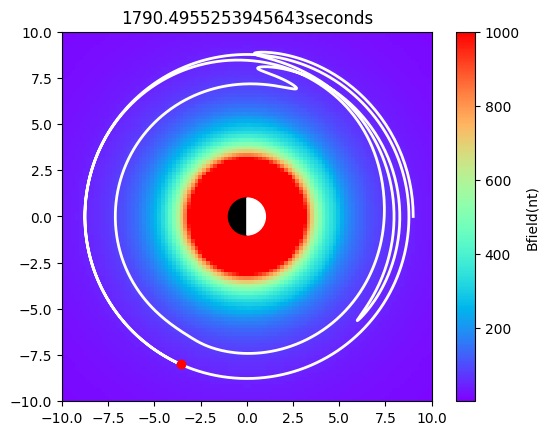

In [233]:
pulse_width = 0.5e7
pulse_velocity = 1e5
# 绘制整个区域的的磁场
L = 9
kev = 1000
input_parameters = {
    "xmu": -1, # -1 for electron, 1 for proton
    "IOPT": 1, # = kp + 1
    "raddist0": L, # initial L
    "longi0": 0, # intital phi
    'pa':90, # pitch angle
    "KEc0": kev, # initial kinetic energy /KeV
    "timedir": 1,
    "Tout": 60,
    "Dmin": 0,
    "pulse_flag": 1, 
    "tmax": 30, # maximum simulation time /min
} 
pulse_parameters = {
    "phi0":0,
    "E0": 2.5, # 5mV/m
    "c0":1,
    "c1":1,
    "c2":0,
    "c3":1,
    "p":1,
    "va":50000,
    "ri":0.6371E8, # m ri/vpulse determine the arrival time of pusle
    "ti":300,
    "di":pulse_width, # width of the pusle
    "rd":1.03, # pulse rebound at rd/2 Re
    "vpulse": pulse_velocity, # m/s
    "duration" : 450 # s 
}
p1 = prt_sim(input_parameters, pulse_parameters, {})
p1_r, p1_t, p1_wtot = p1.prt_sim()    
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
Xm, Ym, Tm = np.meshgrid(x, y, p1_t, indexing='ij')
Zm = np.zeros_like(Xm)
pulse = p1.pulse_fields(1, Tm, Xm, Ym, Zm)
Bpulse = pulse[0]
# Bpulse_magnitude = np.sqrt(Bpulse[0]**2 + Bpulse[1]**2 + Bpulse[2]**2)

B_bg = np.array(p1.MAG(Tm, 0, Xm, Ym, Zm))
B_tot = B_bg + Bpulse
B_tot_magtitude = np.sqrt(B_tot[0]**2 + B_tot[1]**2 + B_tot[2]**2)

fig, ax = plt.subplots(1,1)
xdata = []
ydata = []
line, = ax.plot(xdata, ydata, lw=2, color='white')
point, = ax.plot([], [], 'ro')

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_aspect("equal")
# 添加地球
left_half = patches.Wedge((0, 0), 1, 90, 270, color='black', zorder=3)
right_half = patches.Wedge((0, 0), 1, 270, 90, color='white', zorder=3)
ax.add_patch(left_half)
ax.add_patch(right_half)
cmesh = ax.pcolormesh(Xm[:,:,0], Ym[:,:,0], B_tot_magtitude[:, :, 0], cmap=cm.rainbow, vmin=1e0, vmax=1e3, zorder=1)
cbar = fig.colorbar(cmesh, label="Bfield(nt)", location="right")

# # 使用科学计数法格式化颜色条
# cbar.formatter = ticker.ScalarFormatter()
# cbar.formatter.set_powerlimits((0, 0))  # 强制使用科学计数法
# cbar.update_ticks()  # 更新刻度以应用新格式

step = 5
frames = int(len(p1_t)/step)

def init():
    line.set_data([], [])
    point.set_data([], [])
    return line,point
def update(frame):

    i = frame*step
    # t = times[i].squeeze()
    xdata = [r[0] for r in p1_r][:i]
    ydata = [r[1] for r in p1_r][:i]
    line.set_data(xdata, ydata)
    try:
        point.set_data(xdata[-1], ydata[-1])
    except:
        point.set_data([], [])

    # k = int(np.shape(B_tot_magtitude)[-1] / frames * frame)
    cmesh = ax.pcolormesh(Xm[:,:,i], Ym[:,:,i], B_tot_magtitude[:, :, i], cmap=cm.rainbow, vmin=1e0, vmax=1e3, zorder=1)
    ax.set_title(str(p1_t[i]) + 'seconds')
    return cmesh, line, point

ani = animation.FuncAnimation(fig, update, frames=frames, init_func=init, interval=5, blit=True)
ani.save('./gifs/test_Bfield_L={}_W={}.gif'.format(L, kev), writer='imagemagick')  # 使用imagemagick写入GIF


3.5 500 109 0 0.0
3.5 800 124 0 0.0
3.5 1000 99 8 0.08
3.5 1500 76 23 0.3
3.5 1800 213 52 0.24
3.5 2100 250 46 0.18
3.5 2600 369 2 0.01
3.5 3400 400 33 0.08
3.5 4200 533 103 0.19
3.5 5200 413 0 0.0


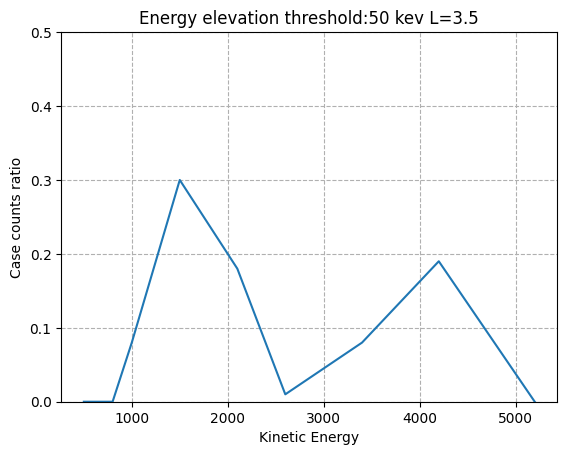

In [108]:
result_name = "result_simpliest"
threshold = 1.1
abs_shreshold = 50
L = 3.5
df = pd.DataFrame(columns=['L', 'Kinetic Energy', 'Total particle num', 'Case particle num', 'ratio'])
for KEc in [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]:
    # KEc = 1800
    kec_list = np.load("G:\pulse_simulation2/{}/sate_data/kec_{}.npy".format(result_name, KEc))
    case_particle_indexes = []
    for i in range(np.shape(kec_list)[-1]):
        if np.linalg.norm(kec_list[0,:2,i])> L-0.05 and np.linalg.norm(kec_list[0,:2,i])<L+0.05:
            case_particle_indexes.append(i)

    E_inc_indexes = []
    for k in case_particle_indexes:
        if kec_list[-1, 2, k] - kec_list[0, 2, k] < - abs_shreshold:
            E_inc_indexes.append(k)
    print(L, KEc, len(case_particle_indexes), len(E_inc_indexes), np.round(len(E_inc_indexes)/len(case_particle_indexes), 2))
    df.loc[len(df)] = [L, KEc, len(case_particle_indexes), len(E_inc_indexes), np.round(len(E_inc_indexes)/len(case_particle_indexes),2)]

x = df['Kinetic Energy']
y = df['ratio']
fig, ax = plt.subplots()
ax.plot(x, y)
ax.grid(linestyle='--')
ax.set_ylim(0, 0.5)
ax.set_xlabel("Kinetic Energy")
ax.set_ylabel("Case counts ratio")
ax.set_title("Energy elevation threshold:{} kev L={:.1f}".format(abs_shreshold, L))
fig.savefig("./{}/figs/{}_{}.png".format(result_name, L, abs_shreshold))

(241,)
(278,)
(435,)
(489,)


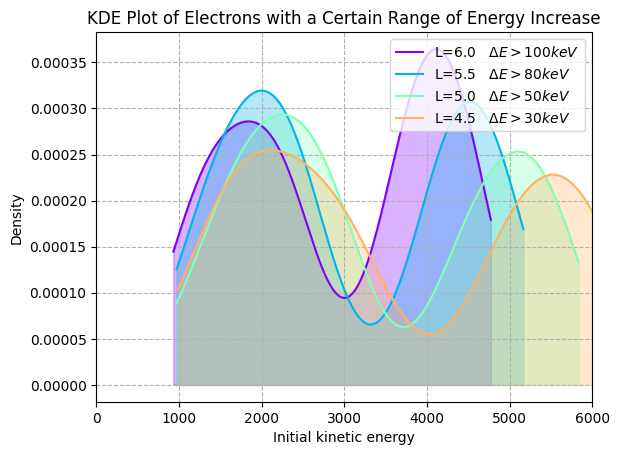

In [556]:
result_name = "result_simpliest"
threshold = 1.1
abs_shresholds = np.array([100, 80, 50 , 30])
Ls = [6, 5.5, 5, 4.5]
incident_init_energies_list = []
for j in range(len(Ls)):
    L = Ls[j]
    abs_shreshold = abs_shresholds[j]
    incident_init_energies = []
    for KEc in [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]:
        # KEc = 1800
        kec_list = np.load("I:\Geoparticle-simulation/result_compressedfield\processed_results\init_kec_batch\{:.1f}.npy".format(KEc))
        case_particle_indexes = []
        for i in range(np.shape(kec_list)[0]):
            if kec_list[i,5,0]> L-0.05 and kec_list[i,5,0]<L+0.05:
                case_particle_indexes.append(i)
        E_inc_indexes = []
        for k in case_particle_indexes:
            if kec_list[k, 4, -1] - kec_list[k, 4, 0] > abs_shreshold * 1000 * C.elementary_charge:
                E_inc_indexes.append(k)
        incident_init_energies.extend(list(kec_list[E_inc_indexes, 4, 0] / (1000*C.elementary_charge)))
    incident_init_energies_list.append(incident_init_energies)

from scipy.stats import gaussian_kde

fig, ax = plt.subplots()
cmp = plt.get_cmap("rainbow")
for i in range(len(Ls)):
    data = incident_init_energies_list[i]
    print(np.shape(data))
    kde = gaussian_kde(data)
    x_vals = np.linspace(min(data), max(data), 1000)
    kde_vals = kde(x_vals)
    
    # 绘制 KDE 图
    color = cmp(i/4)
    ax.plot(x_vals, kde_vals, color=color, label='L={:.1f}   $\Delta E > {} keV$'.format(Ls[i], abs_shresholds[i]))
    ax.fill_between(x_vals, kde_vals, color=color, alpha=0.3)
    ax.set_xlabel("Initial kinetic energy")
    ax.set_ylabel("Density")
    ax.set_xlim(0,6000)
    ax.set_title("KDE Plot of Electrons with a Certain Range of Energy Increase")
    ax.grid(linestyle='--')
    ax.legend(loc=1)

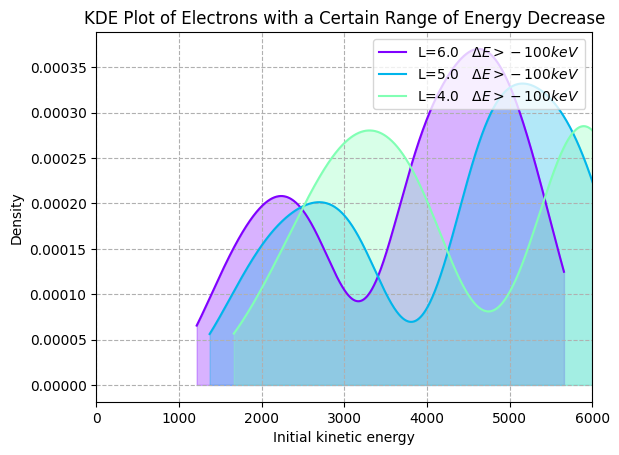

In [ ]:
result_name = "result_simpliest"
threshold = 1.1
abs_shresholds = [-100, -100, -100]
Ls = [6, 5, 4]
incident_init_energies_list = []
for j in range(len(Ls)):
    L = Ls[j]
    abs_shreshold = abs_shresholds[j]
    incident_init_energies = []
    for KEc in [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]:
        # KEc = 1800
        kec_list = np.load("I:\Geoparticle-simulation/result_compressedfield\processed_results\init_kec_batch\{:.1f}.npy".format(KEc))
        case_particle_indexes = []
        for i in range(np.shape(kec_list)[0]):
            if kec_list[i,5,0]> L-0.05 and kec_list[i,5,0]<L+0.05:
                case_particle_indexes.append(i)

        E_inc_indexes = []
        for k in case_particle_indexes:
            if kec_list[k, 4, -1] - kec_list[k, 4, 0] < abs_shreshold * 1000 * C.elementary_charge:
                E_inc_indexes.append(k)
        incident_init_energies.extend(list(kec_list[E_inc_indexes, 4, 0] / (1000*C.elementary_charge)))
    incident_init_energies_list.append(incident_init_energies)
from scipy.stats import gaussian_kde

fig, ax = plt.subplots()
cmp = plt.get_cmap("rainbow")
for i in range(len(Ls)):
    data = incident_init_energies_list[i]
    kde = gaussian_kde(data)
    x_vals = np.linspace(min(data), max(data), 1000)
    kde_vals = kde(x_vals)
    
    # kde_vals_normalized = kde_vals / max(kde_vals)
    # 绘制 KDE 图
    color = cmp(i/4)
    ax.plot(x_vals, kde_vals, color=color, label='L={:.1f}   $\Delta E > {} keV$'.format(Ls[i], abs_shresholds[i]))
    ax.fill_between(x_vals, kde_vals, color=color, alpha=0.3)
    ax.set_xlabel("Initial kinetic energy")
    ax.set_ylabel("Density")
    ax.set_xlim(0,6000)
    ax.set_title("KDE Plot of Electrons with a Certain Range of Energy Decrease")
    ax.grid(linestyle='--')
    ax.legend(loc=1)    
    ax

In [115]:
std_file = r"./std_files/std_file.csv"
df_std = pd.read_csv(std_file)
times = df_std[["time(sec)"]].to_numpy().squeeze()

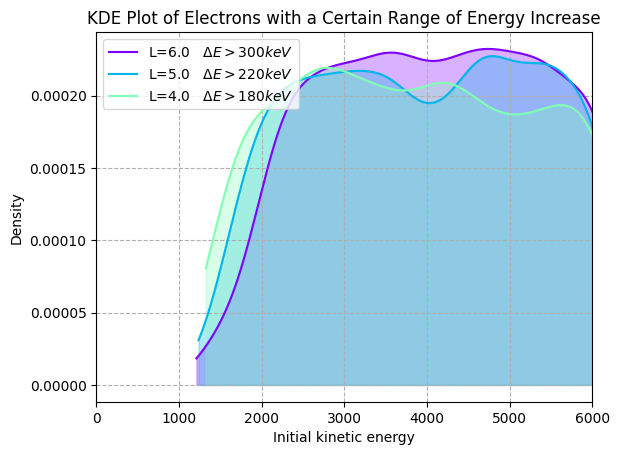

In [575]:
result_name = "result_simpliest"
threshold = 1.1
abs_shresholds = [300, 220, 180]
Ls = [6, 5, 4]
incident_init_energies_list = []
for j in range(len(Ls)):
    L = Ls[j]
    abs_shreshold = abs_shresholds[j]
    incident_init_energies = []
    for KEc in [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]:
        # KEc = 1800
        kec_list = np.load("I:\Geoparticle-simulation/result_compressedfield\processed_results\init_kec_batch\{:.1f}.npy".format(KEc))
        case_particle_indexes = []
        for i in range(np.shape(kec_list)[0]):
            if kec_list[i,5,0]> L-0.05 and kec_list[i,5,0]<L+0.05:
                case_particle_indexes.append(i)
        E_inc_indexes = []
        for k in case_particle_indexes:
            if kec_list[k, 4, 95] - kec_list[k, 4, 0] > abs_shreshold * 1000 * C.elementary_charge:
                E_inc_indexes.append(k)
        incident_init_energies.extend(list(kec_list[E_inc_indexes, 4, 0] / (1000*C.elementary_charge)))
    incident_init_energies_list.append(incident_init_energies)

from scipy.stats import gaussian_kde

fig, ax = plt.subplots()
cmp = plt.get_cmap("rainbow")
for i in range(len(Ls)):
    data = incident_init_energies_list[i]
    kde = gaussian_kde(data)
    x_vals = np.linspace(min(data), max(data), 1000)
    kde_vals = kde(x_vals)
    
    # 绘制 KDE 图
    color = cmp(i/4)
    ax.plot(x_vals, kde_vals, color=color, label='L={:.1f}   $\Delta E > {} keV$'.format(Ls[i], abs_shresholds[i]))
    ax.fill_between(x_vals, kde_vals, color=color, alpha=0.3)
    ax.set_xlabel("Initial kinetic energy")
    ax.set_ylabel("Density")
    ax.set_xlim(0,6000)
    ax.set_title("KDE Plot of Electrons with a Certain Range of Energy Increase")
    ax.grid(linestyle='--')
    ax.legend(loc=2)
    # ax.text()

2864 2864
2886 2886
1414 1414


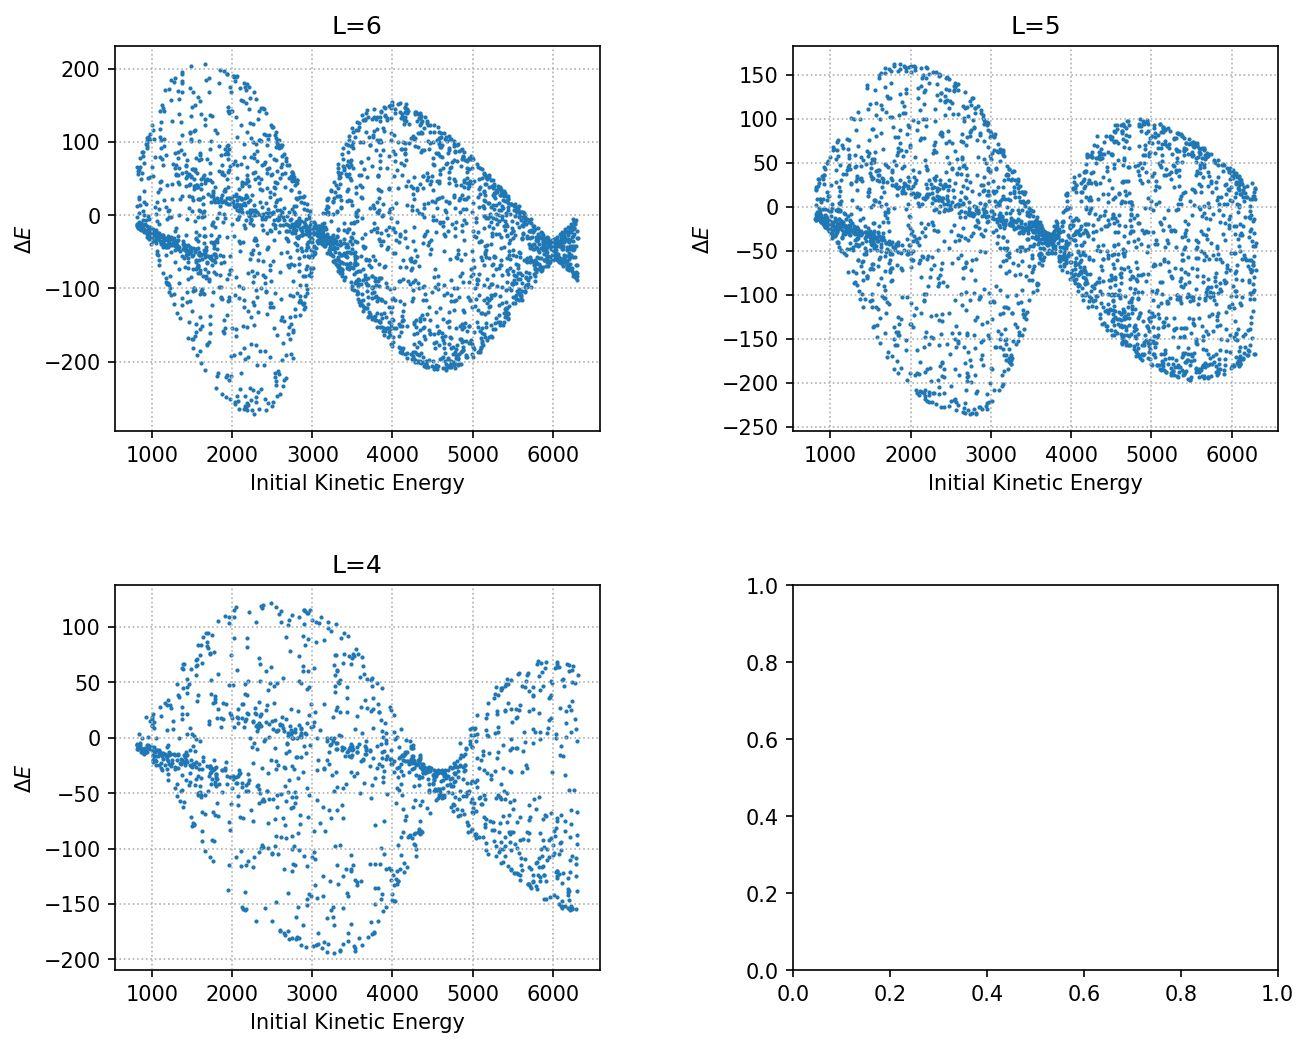

In [578]:
result_name = "result_simpliest"
threshold = 1.1
Ls = [6, 5, 4]
fig, axs = plt.subplots(2,2, figsize=(10,8), dpi=150)
axs = axs.flatten()
fig.subplots_adjust(wspace=0.4, hspace=0.4)
for j in range(len(Ls)):
    L = Ls[j]
    Es_list = []
    deltaE_list = []
    for KEc in [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]:
        # KEc = 1800
        kec_list = np.load("I:\Geoparticle-simulation/result_compressedfield\processed_results\init_kec_batch\{:.1f}.npy".format(KEc))
        case_particle_indexes = []
        for i in range(np.shape(kec_list)[0]):
            if kec_list[i,5,0]> L-0.05 and kec_list[i,5,0]<L+0.05:
                case_particle_indexes.append(i)
        deltaEs = []
        for k in case_particle_indexes:
            deltaE = kec_list[k, 4, -1] - kec_list[k, 4, 0]
            deltaEs.append(deltaE)
        deltaE_list.extend(deltaEs)
        Es_list.extend(kec_list[case_particle_indexes, 4, 0])
    print(len(deltaE_list), len(Es_list))
    
    ax = axs[j]
    ax.scatter(np.array(Es_list)/(1000*C.elementary_charge), np.array(deltaE_list)/(1000*C.elementary_charge), s=1)
    ax.set_xlabel("Initial Kinetic Energy")
    ax.set_ylabel("$\Delta E$")
    ax.grid(linestyle=':')
    ax.set_title("L={}".format(L))
    # ax.set_ylim(-250, 300)


30.02495770500502
max running time


MovieWriter imagemagick unavailable; using Pillow instead.


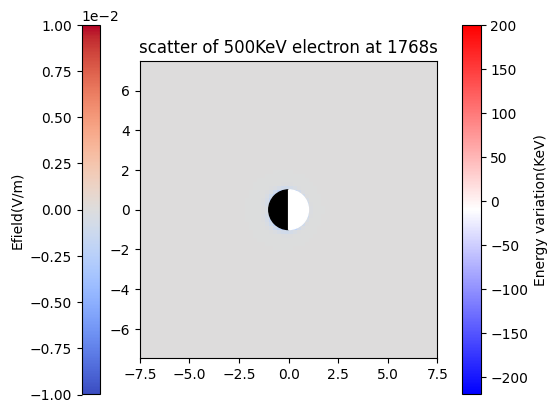

In [3]:
KEcs = [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]
# KEcs = [3400, 4200, 5200]
KEcs = [500]

result_name = "result_simpliest"
std_file = r"./std_files/std_file.csv"
df = pd.read_csv(std_file)
times = df[["time(sec)"]].to_numpy()

pulse_width = 2e7
pulse_velocity = 1
# 绘制整个区域的的电场
input_parameters = {
    "xmu": -1, # -1 for electron, 1 for proton
    "IOPT": 1, # = kp + 1
    "raddist0": 6, # initial L
    "longi0": 0, # intital phi
    'pa':90, # pitch angle
    "KEc0": 3400, # initial kinetic energy /KeV
    "timedir": 1,
    "Tout": 60,
    "Dmin": 0,
    "pulse_flag": 1, 
    "tmax": 30, # maximum simulation time /min
} 
pulse_parameters = {
    "phi0":0,
    "E0": 5, # 5mV/m
    "c0":1,
    "c1":1,
    "c2":0,
    "c3":1,
    "p":0.4,
    "va":50000,
    "ri":0.6371E8 * 1.5, # m ri/vpulse determine the arrival time of pusle
    "ti":0,
    "di":pulse_width, # width of the pusle
    "rd":2.06, # pulse rebound at rd/2 Re
    "vpulse": pulse_velocity, # m/s
    "duration" : 450 # s 
}
p1 = prt_sim(input_parameters, pulse_parameters, {})
p1_r, p1_t, p1_wtot = p1.prt_sim()    
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
Xm, Ym, Tm = np.meshgrid(x, y, p1_t, indexing='ij')
Zm = np.zeros_like(Xm)
pulse = p1.pulse_fields(1, Tm, Xm, Ym, Zm)
Epulse = pulse[0]
Epulse_magnitude = np.sqrt(Epulse[0]**2 + Epulse[1]**2 + Epulse[2]**2)

# 确定电场方向与位置向量的关系来区分正负电场 
checker = np.zeros_like(Epulse_magnitude)
for index, value in np.ndenumerate(Epulse):
    xindex, yindex, tindex = index[-3], index[-2], index[-1]
    Ex = Epulse[0, xindex, yindex, tindex]
    Ey = Epulse[1, xindex, yindex, tindex]
    x = Xm[xindex, yindex, tindex]
    y = Ym[xindex, yindex, tindex]
    E = np.array([Ex, Ey])
    pos = np.array([x, y])
    cross_product = E[0] * pos[1] - E[1] * pos[0]
    if cross_product < 0 :
        checker[xindex, yindex, tindex] = -1 # 逆时针，即电场方向与电子漂移同向
    elif cross_product > 0:
        checker[xindex, yindex, tindex] = 1 # 顺时针，反向
    else:
        checker[xindex, yindex, tindex] = 0
Epulse_magnitude = checker * Epulse_magnitude


for KEc in KEcs:
    step = 5
    frames = int((len(times) - 1)/step)
    kec_list = np.load("./{}/sate_data/kec_{}.npy".format(result_name, KEc))
    kec_list = np.zeros_like(kec_list)
    fig, ax = plt.subplots(1,1)
    scatter = ax.scatter(kec_list[0, 0, :], kec_list[0,1,:], c=kec_list[0,2,:]-kec_list[0,2,:], vmin=200, vmax=-200, s=1, cmap='bwr', zorder=2)
    ax.figure.colorbar(scatter, ax=ax, label='Energy variation(KeV)')
    ax.set_xlim(-7.5, 7.5)
    ax.set_ylim(-7.5, 7.5)
    ax.set_aspect("equal")
    # 添加地球
    left_half = patches.Wedge((0, 0), 1, 90, 270, color='black', zorder=3)
    right_half = patches.Wedge((0, 0), 1, 270, 90, color='white', zorder=3)
    ax.add_patch(left_half)
    ax.add_patch(right_half)
    

    cmesh = ax.pcolormesh(Xm[:,:,0], Ym[:,:,0], Epulse_magnitude[:, :, 0], cmap=cm.coolwarm, vmin=-1e-2, vmax=1e-2, zorder=1)
    cbar = fig.colorbar(cmesh, label="Efield(V/m)", location="left")
    
    # 使用科学计数法格式化颜色条
    cbar.formatter = ticker.ScalarFormatter()
    cbar.formatter.set_powerlimits((0, 0))  # 强制使用科学计数法
    cbar.update_ticks()  # 更新刻度以应用新格式

    
    def update(frame):

        i = frame*step
        t = times[i].squeeze()
        X = kec_list[i, 0, :]
        Y = kec_list[i, 1, :]
        c = kec_list[i, 2, :]
 
        scatter.set_offsets(np.column_stack((kec_list[i, 0, :], kec_list[i, 1, :])))
        scatter.set_array(kec_list[i, 2, :]-kec_list[0,2,:])
        # im.set_array(heatmap)
        ax.set_title('scatter of {}KeV electron at {:.0f}s'.format(KEc, t))
        ax.set_xlim(-7.5, 7.5)
        ax.set_ylim(-7.5, 7.5)

        k = int(np.shape(Epulse_magnitude)[-1] / frames * frame)
        cmesh = ax.pcolormesh(Xm[:,:,k], Ym[:,:,k], Epulse_magnitude[:, :, k], cmap='coolwarm', vmin= -1e-2, vmax=1e-2, zorder=1)
  
        return cmesh,

    ani = animation.FuncAnimation(fig, update, frames=frames, interval=5, blit=True)
    if not os.path.exists("./{}/gifs/".format(result_name)):
        os.makedirs("./{}/gifs/".format(result_name))
    ani.save('./{}/gifs/efield.gif'.format(result_name), writer='imagemagick')  # 使用imagemagick写入GIF

2689 2689
2815 2815
2702 2702
2730 2730


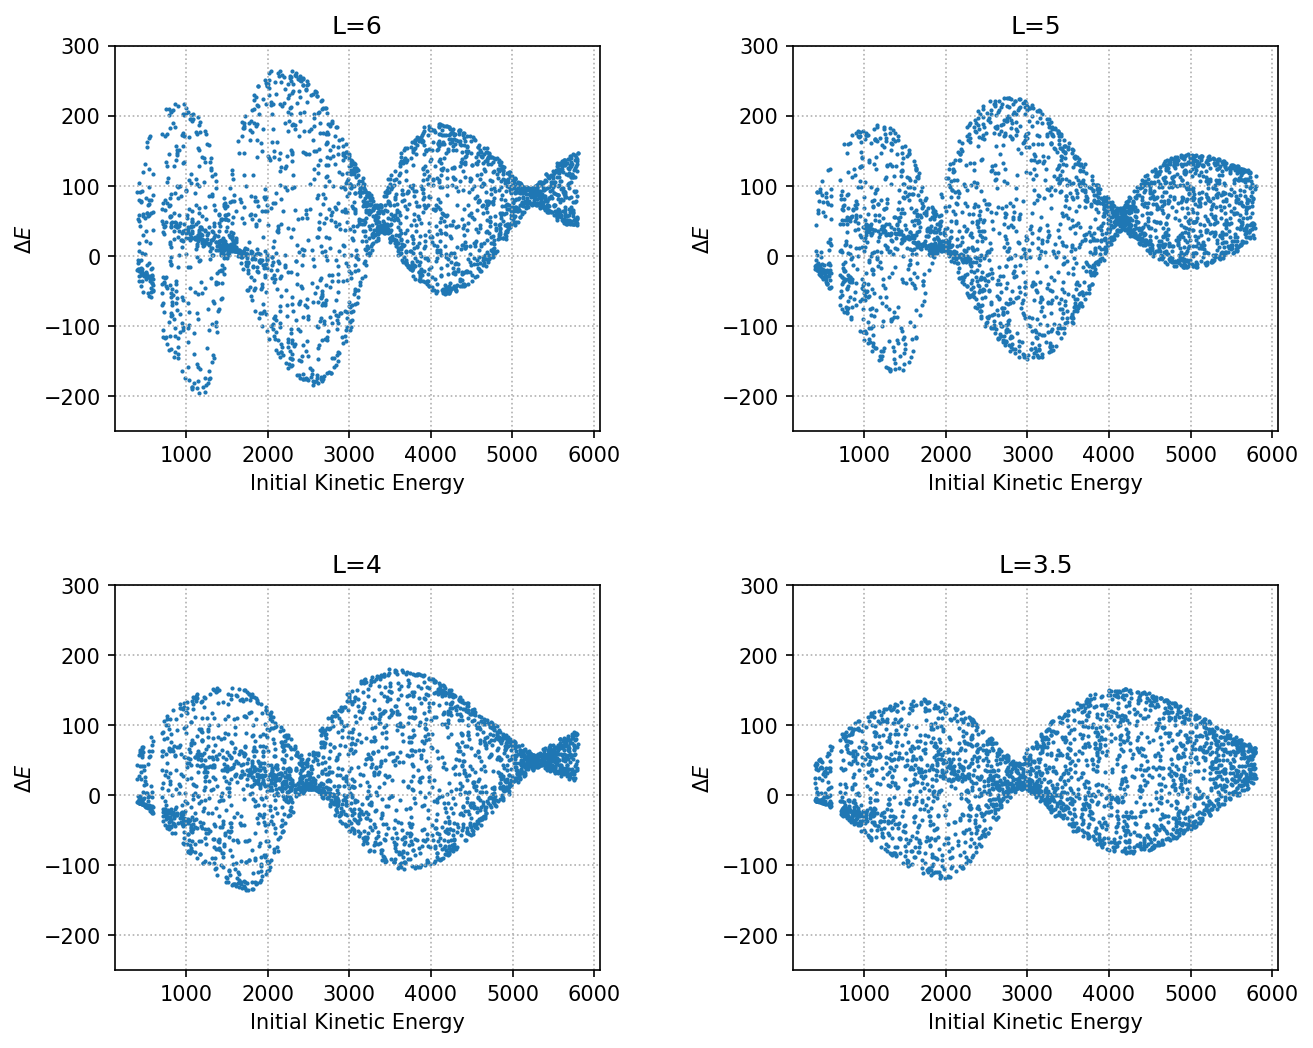

In [10]:
result_name = "result_simpliest"
subfolder_name = "doublegaussfullfit_exp"
threshold = 1.1
Ls = [6, 5, 4, 3.5]
fig, axs = plt.subplots(2,2, figsize=(10,8), dpi=150)
axs = axs.flatten()
fig.subplots_adjust(wspace=0.4, hspace=0.4)
for j in range(len(Ls)):
    L = Ls[j]
    Es_list = []
    deltaE_list = []
    for KEc in [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200]:
        # KEc = 1800
        kec_list = np.load("G:\pulse_simulation2/{}/{}/sate_data/kec_{}.npy".format(result_name,subfolder_name ,KEc))
        case_particle_indexes = []
        for i in range(np.shape(kec_list)[-1]):
            if np.linalg.norm(kec_list[0,:2,i])> L-0.05 and np.linalg.norm(kec_list[0,:2,i])<L+0.05:
                case_particle_indexes.append(i)
        deltaEs = []
        for k in case_particle_indexes:
            deltaE = kec_list[-1, 2, k] - kec_list[0, 2, k] 
            deltaEs.append(deltaE)
        deltaE_list.extend(deltaEs)
        Es_list.extend(kec_list[0, 2, case_particle_indexes])
    print(len(deltaE_list), len(Es_list))
    
    ax = axs[j]
    ax.scatter(Es_list, deltaE_list, s=1)
    ax.set_xlabel("Initial Kinetic Energy")
    ax.set_ylabel("$\Delta E$")
    ax.grid(linestyle=':')
    ax.set_title("L={}".format(L))
    ax.set_ylim(-250, 300)


In [563]:
data = np.load("./result_compressedfield/results_batch/batch_1.npy")

364.503039884291
364.503039884291
364.503039884291


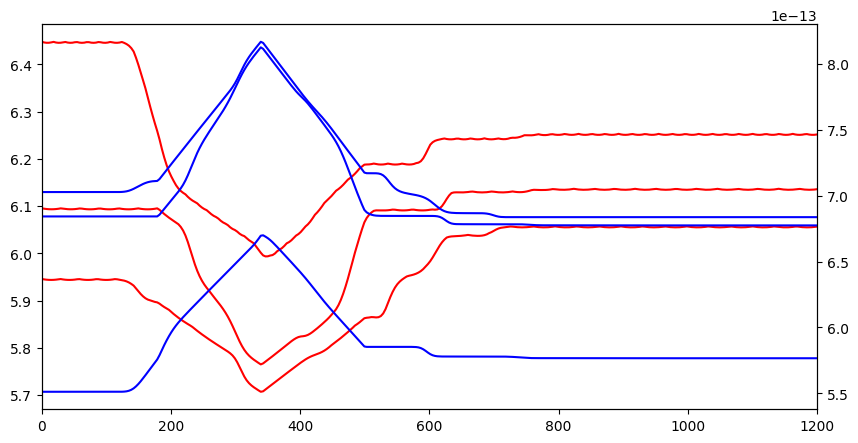

In [570]:
i = 1503
fig, ax = plt.subplots(figsize=(10,5))
ax2 = ax.twinx()
for i in range(344,347):
    x = data[i, 1, :]
    
    y = data[i, 2, :]
    z = data[i, 3, :]
    t = data[i, 0, :]
    print(t[100])
    w = data[i, 4, :]
    r = np.sqrt(x**2 + y**2)
    
    
    ax.plot(t, r, c='r', label="r")
    ax2.plot(t, w, c='b', label="w")
    ax.set_xlim(0,1200)
    # fig.legend(loc=2)

能道标签 (随时间变化) 数组形状: (5000, 494)
Time=0s, 能道 1500 keV 粒子数量: 363


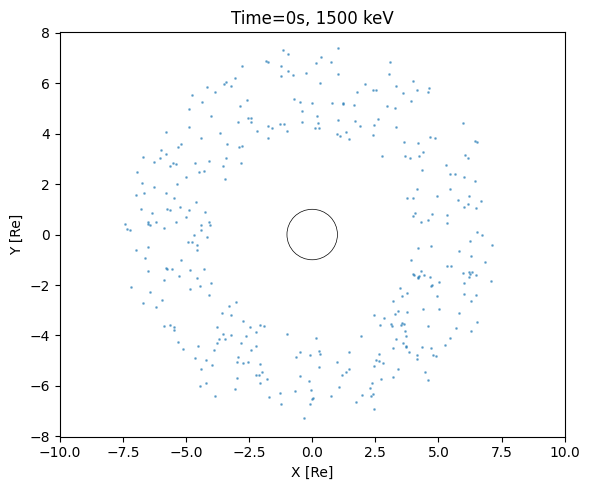

Time=91s, 能道 1500 keV 粒子数量: 365


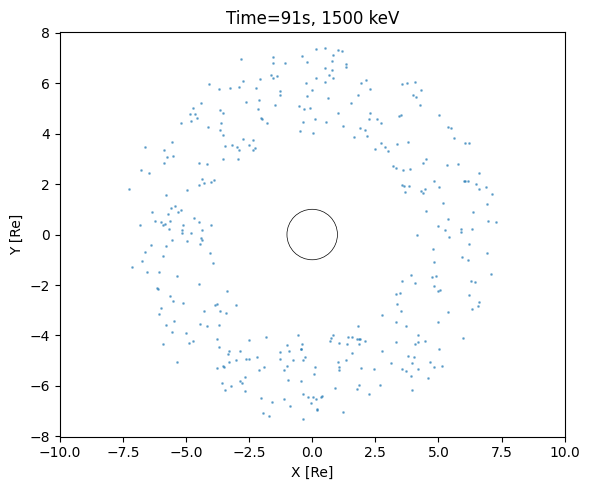

Time=186s, 能道 1500 keV 粒子数量: 359


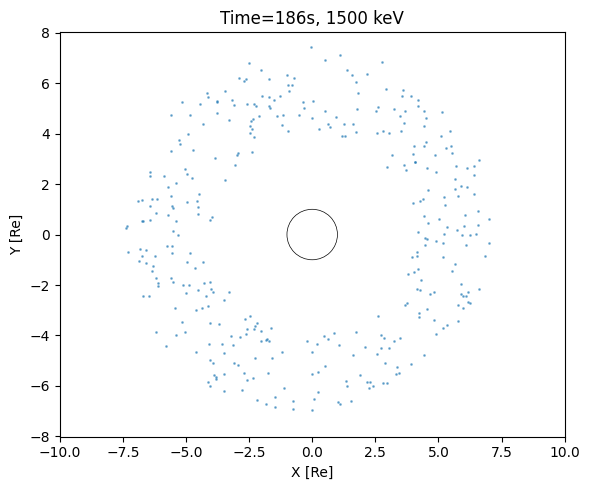

Time=281s, 能道 1500 keV 粒子数量: 318


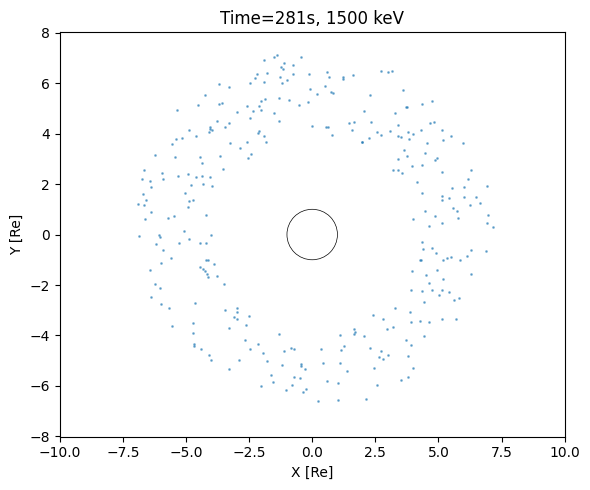

Time=375s, 能道 1500 keV 粒子数量: 283


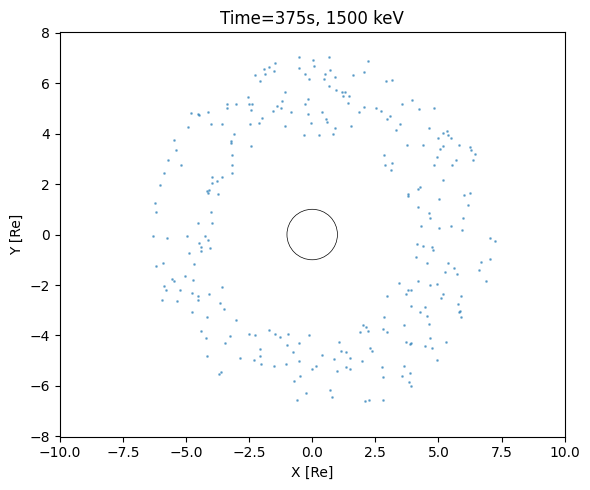

Time=470s, 能道 1500 keV 粒子数量: 333


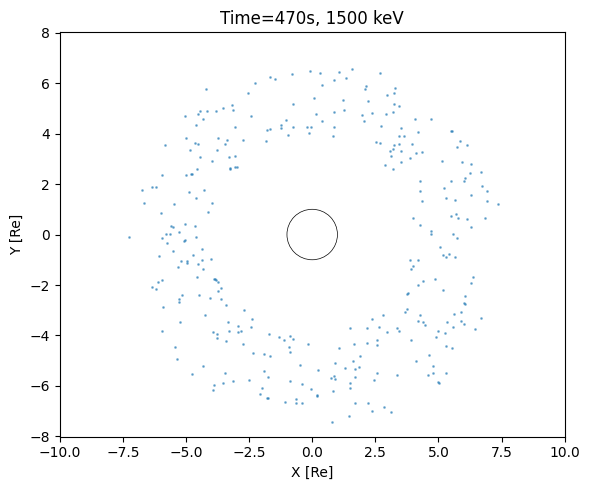

Time=565s, 能道 1500 keV 粒子数量: 357


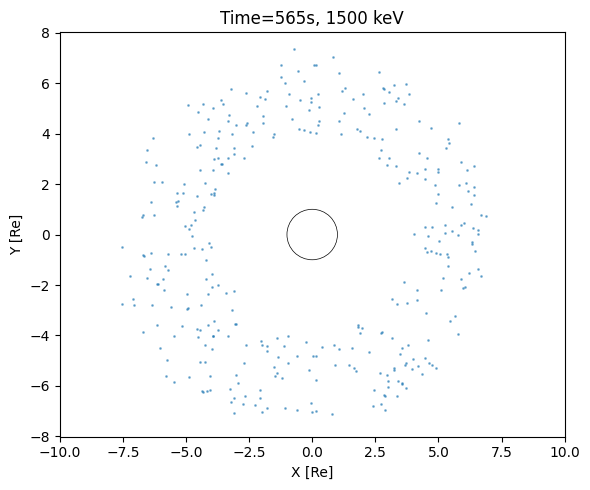

Time=660s, 能道 1500 keV 粒子数量: 350


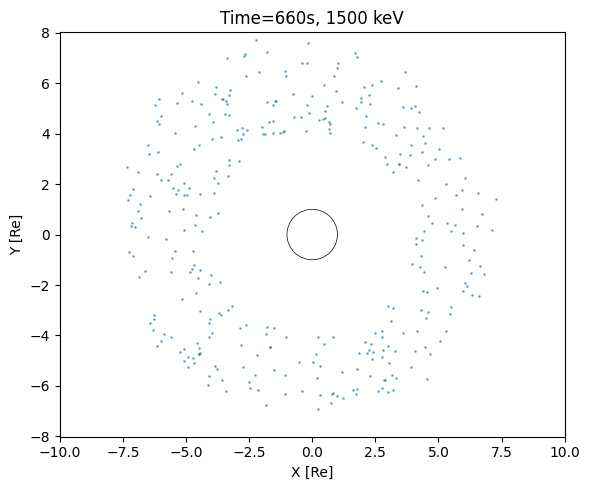

Time=755s, 能道 1500 keV 粒子数量: 358


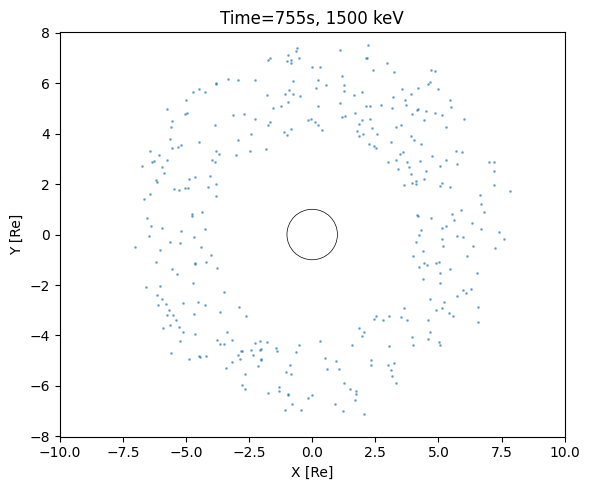

Time=849s, 能道 1500 keV 粒子数量: 357


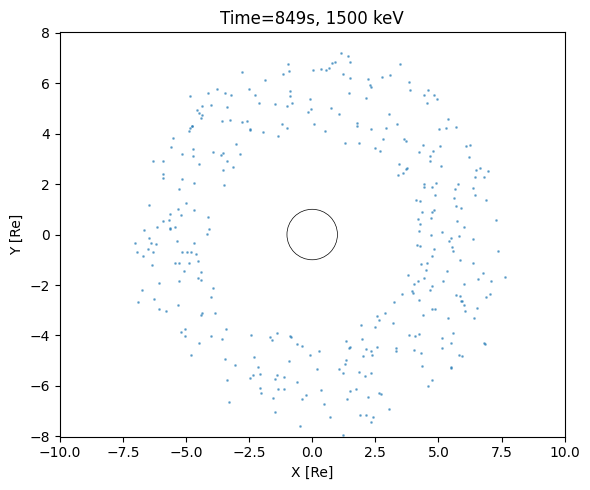

Time=944s, 能道 1500 keV 粒子数量: 357


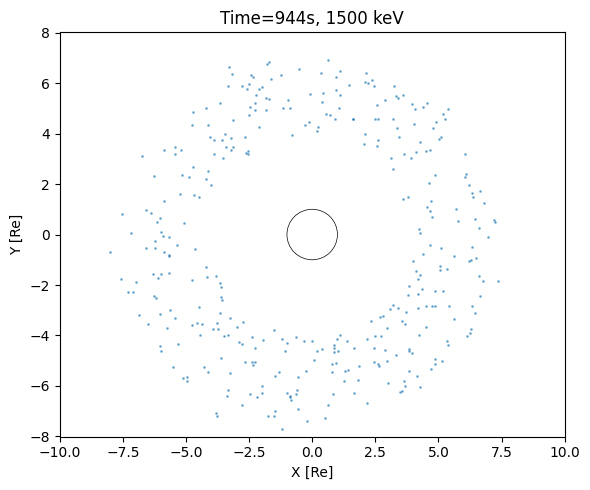

Time=1039s, 能道 1500 keV 粒子数量: 357


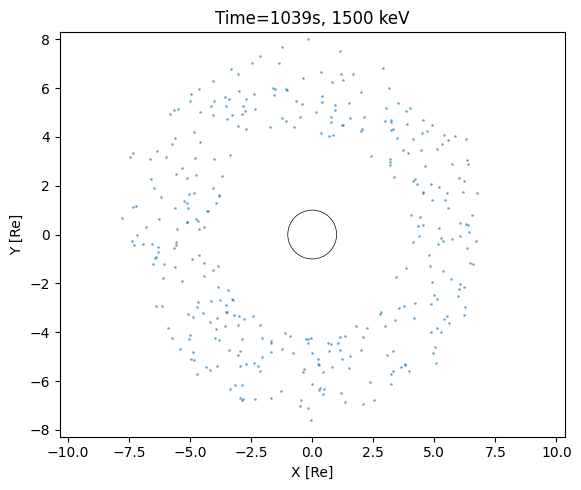

Time=1134s, 能道 1500 keV 粒子数量: 357


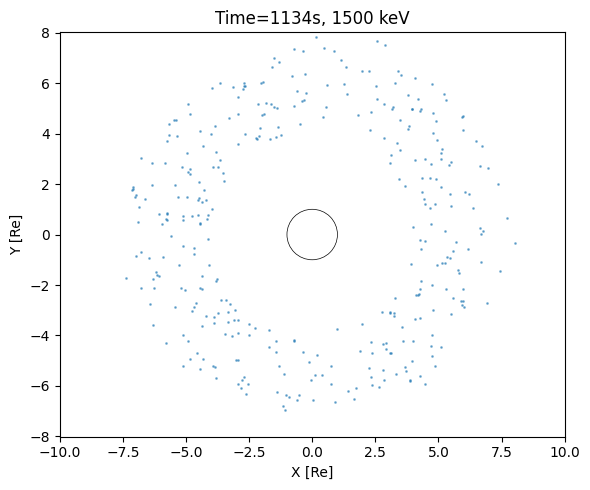

Time=1228s, 能道 1500 keV 粒子数量: 357


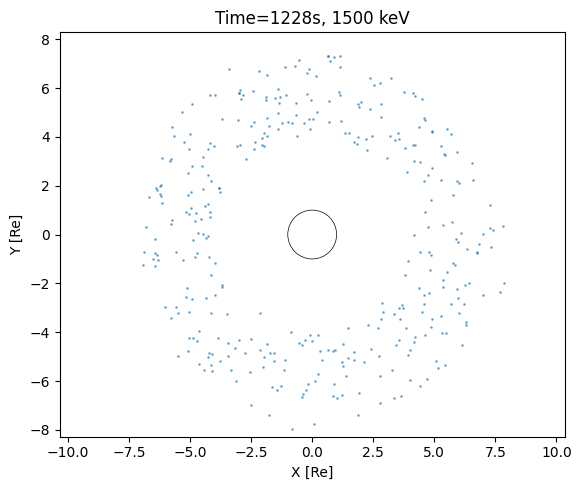

Time=1323s, 能道 1500 keV 粒子数量: 357


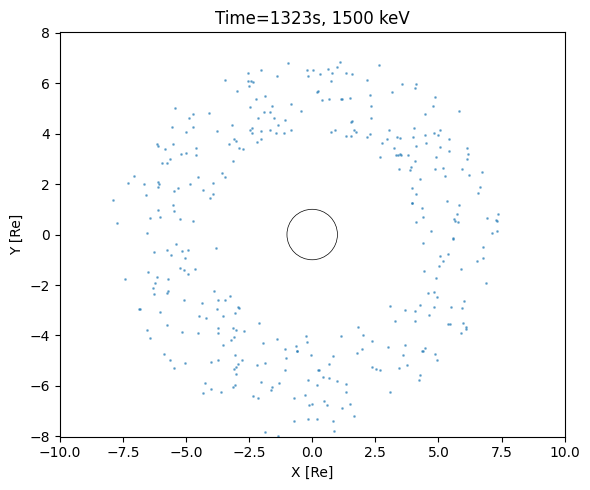

Time=1418s, 能道 1500 keV 粒子数量: 357


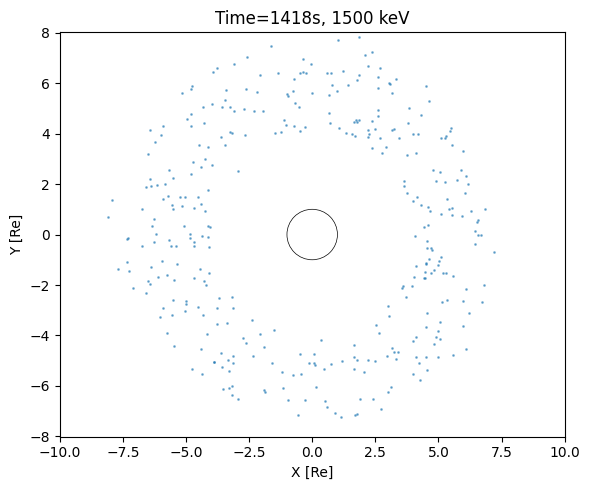

Time=1513s, 能道 1500 keV 粒子数量: 357


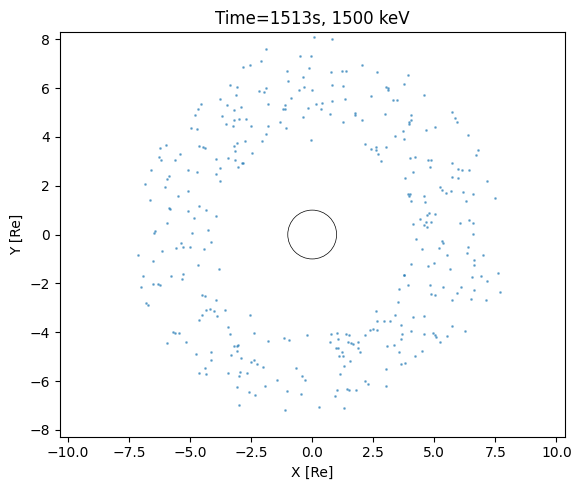

Time=1607s, 能道 1500 keV 粒子数量: 357


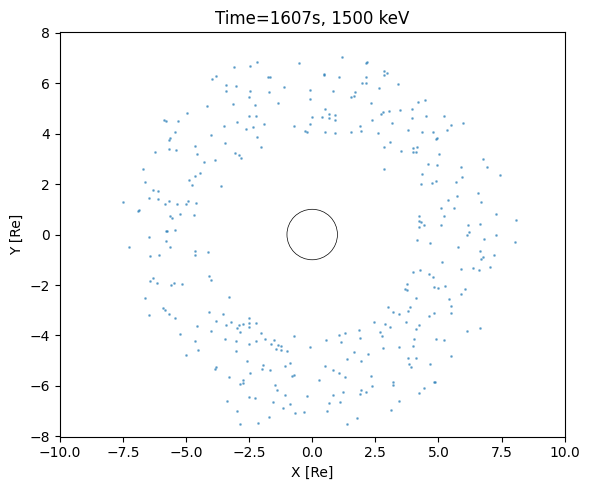

Time=1702s, 能道 1500 keV 粒子数量: 357


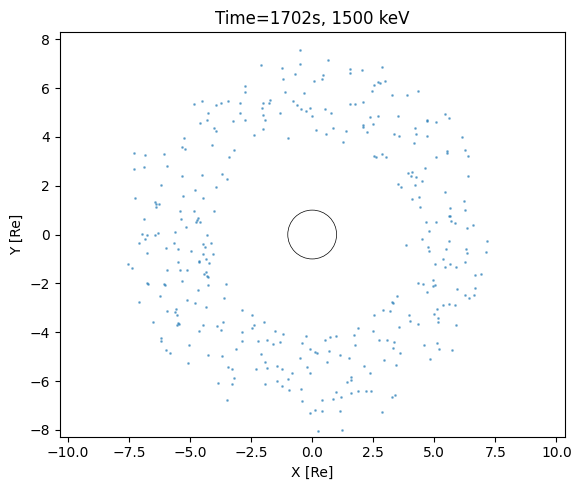

Time=1797s, 能道 1500 keV 粒子数量: 357


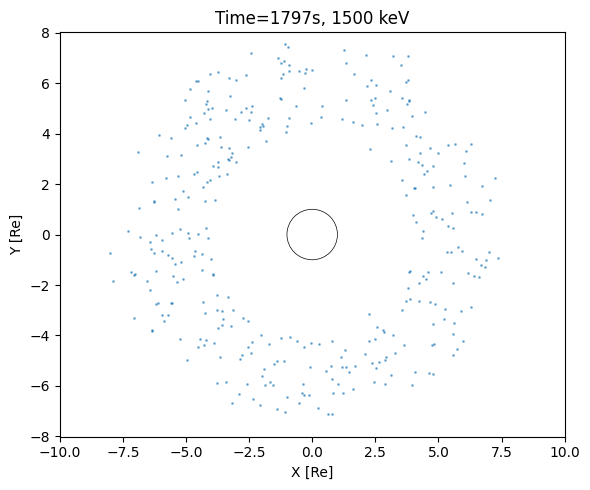

In [175]:
time_series = data[:, 0, :]  # 时间序列 (所有粒子的统一时间轴)
x_coords = data[:, 1, :]      # X 坐标
y_coords = data[:, 2, :]      # Y 坐标
z_coords = data[:, 3, :]      # Z 坐标
energies = data[:, 4, :]      # 总能量 (焦耳)

num_particles = data.shape[0]  # 粒子总数 (batch_size)
num_time_steps = data.shape[2] # 时间步数

energy_lower_MeV = 1.0
energy_upper_MeV = 2.0

# MeV 转换为 焦耳 (Joule)
energy_lower_Joule = energy_lower_MeV * 1e6 * 1.602e-19  # 1 MeV = 1e6 eV, 1 eV = 1.602e-19 J
energy_upper_Joule = energy_upper_MeV * 1e6 * 1.602e-19

def kec_label_batch(wtot_array):
    kec_array = (wtot_array / C.elementary_charge / 1e6 - 0.511) * 1000
    # 定义能道区间和对应的能道标签
    ranges = [
        (300, 700, 500),
        (700, 900, 800),
        (900, 1200, 1000),
        (1200, 1600, 1500),
        (1600, 2000, 1800),
        (2000, 2500, 2100),
        (2500, 3200, 2600),
        (3200, 4000, 3400),
        (4000, 5000, 4200),
        (5000, 6200, 5200),
    ]
    labels = np.zeros_like(kec_array, dtype=int)

    # 根据区间查找标签
    for lower, upper, label in ranges:
        mask = (kec_array > lower) & (kec_array < upper)
        labels[mask] = label
    return labels

energy_channel_labels_over_time = np.zeros_like(energies, dtype=int) 
for time_index in range(num_time_steps):
    current_energies_joule = energies[:, time_index] #  获取当前时间步所有粒子的能量
    energy_channel_labels_over_time[:, time_index] = kec_label_batch(current_energies_joule) #  为当前时间步的所有粒子标记能道

defined_channel_labels = [500, 800, 1000, 1500, 1800, 2100, 2600, 3400, 4200, 5200] #  定义的能道标签列表 (与之前相同)

print("能道标签 (随时间变化) 数组形状:", energy_channel_labels_over_time.shape) #  打印形状，应为 (粒子数, 时间步数)

time_indices_to_plot = np.linspace(0, num_time_steps - 1, num=20, dtype=int)
for time_index in time_indices_to_plot:
    time_val = time_series[0, time_index] # 获取当前时间值

    # for channel_label_kev in defined_channel_labels: #  循环遍历能道
    channel_label_kev = defined_channel_labels[3]
    # 创建当前时间和当前能道的掩码 (mask)  (关键修改!!!)
    channel_mask = (energy_channel_labels_over_time[:, time_index] == channel_label_kev) #  使用 energy_channel_labels_over_time, 并指定 time_index

    # 应用掩码，筛选出当前时间和当前能道内的粒子
    channel_x_coords = x_coords[channel_mask, :]
    channel_y_coords = y_coords[channel_mask, :]
    channel_z_coords = z_coords[channel_mask, :]
    channel_energies = energies[channel_mask, :] # 可选
    num_channel_particles = channel_x_coords.shape[0]

    if num_channel_particles == 0: #  当前时间和当前能道没有粒子，跳过
        print(f"Time={time_val:.0f}s, 能道 {channel_label_kev} keV 没有粒子，跳过可视化.")
        continue

    print(f"Time={time_val:.0f}s, 能道 {channel_label_kev} keV 粒子数量: {num_channel_particles}")

    # --- 可视化空间分布 (例如，二维散点图) ---
    plt.figure(figsize=(6, 5)) #  每个能道一张图，图尺寸缩小
    # 绘制散点图，只绘制当前时间和当前能道内的粒子 (关键修改!!!)
    plt.scatter(channel_x_coords[:, time_index], channel_y_coords[:, time_index], s=1, alpha=0.5) #  使用 channel_x_coords[:, time_index] 和 channel_y_coords[:, time_index]

    plt.title(f'Time={time_val:.0f}s, {channel_label_kev} keV') #  标题包含时间和能道信息
    plt.xlabel('X [Re]')
    plt.ylabel('Y [Re]')
    plt.axis('equal')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.gca().add_patch(plt.Circle((0, 0), 1, color='k', fill=False, linewidth=0.5))

    plt.tight_layout()
    # plt.suptitle(f'Spatial Distribution of Electrons (Time={time_val:.0f}s)', y=1.02) #  总标题可以删除，因为每个能道一张图
    plt.show()

    # --- 可视化径向距离直方图 (可选，类似散点图，只需修改 plt.hist 代码) ---

In [509]:
def read_hdf5_data(batchfolder, batch_idx, kec, timestep):
    """
    读取指定batch、能量和时间点的数据

    Args:
        batch_idx (int): batch索引
        kec (float): 能量值
        timestep (int): 时间点索引

    Returns:
        np.ndarray: 数据数组
    """
    with h5py.File(f"{batchfolder}particle_data_batch{batch_idx}.h5", 'r') as f:
        return f[f"kec_{kec:.1f}/timestep_{timestep}/data"][:]

data = read_hdf5_data(r"I:\Geoparticle-simulation\result_compressedfield\processed_results\timepoint_data/", 0, 3400, 300)

In [510]:
data.shape

(7294, 8)

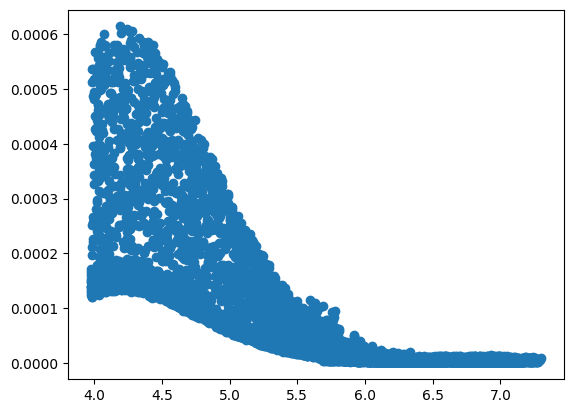

In [500]:
weights = data[:, -1]
L = np.sqrt(data[:, 1] ** 2 + data[:, 2]**2)
plt.scatter(L, weights)
# plt.yscale('log')
# plt.xlim(6,7)
# plt.ylim(0, 1e7)

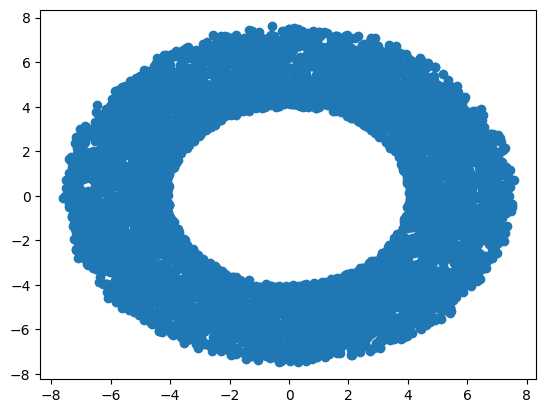

In [512]:
x = data[:, 1]
y = data[:, 2]
plt.scatter(x, y)